In [56]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys

import numpy as np
import matplotlib as mlab
import matplotlib.pyplot as plt
import xarray as xr
import os as os
import glob
import matplotlib.gridspec as gridspec
import metpy.calc as mpcalc
from metpy.units import units
import pickle

import tools

from analysis_tools import generate_ideal_profiles
from tools.cbook import pickle2Obj, get_percentile_value

_nthreads = 2

# Plot styles

plot_styles = {
               'cm1':  {'color': 'k', 'majorlines': 2.0, 'minorlines':0.5 },
               'solo': {'color': 'r', 'majorlines': 2.0, 'minorlines':0.5 },
               'wrf':  {'color': 'r', 'majorlines': 2.0, 'minorlines':0.5 }
               }

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
t = pickle2Obj('cm1_weisman_3km_profiles.pkl', retObj=False)
print(t['qv14'].keys())

dict_keys(['dbz', 'w', 'temp', 'theta', 'thetae', 'pert_t', 'pert_th', 'qv', 'pert_p', 'tindex', 'size'])


In [68]:
#--------------------------------------------------------------------------------------------
def plot_profile(profile, var, zhgts, percentile, ax, color, mlabel, step=-1, 
                 majorwidth=2.0, minorwidth=0.5, errorevery=1, linestyle='solid'):

    # label = "%s NOBJ:  %d" % (mlabel, profile[var].shape[1])
    label = ""

    p = profile[var]
        
    if step != -1:
        t0 = profile['tindex'][step[0]]
        t1 = profile['tindex'][step[1]]
        p = p[:,t0:t1]
        
    label = "%s NOBJ:  %d" % (mlabel, p.shape[1])       
    
    ax.errorbar(p.mean(axis=1), zhgts, xerr=p.std(axis=1), elinewidth=minorwidth, errorevery=2, \
                color=color, linewidth=majorwidth, label=label, linestyle=linestyle)
#--------------------------------------------------------------------------------------------
# define plotting sub

def plot_wprofile_driver(models, runs = None, plot_label = ""):

    titles = ["0-2 Hour Updraft Profiles", "2-4 Hour Updraft Profiles", "4-6 Hour Updraft Profiles"]

    xvert  = [6.0, 8.0, 12.5]
    xlim   = [10., 15.0, 20.0]

    zhgts = 250. + 250.*np.arange(100)
    
    step = [[0,8],[8,16],[16,24]]

    for run in runs:

        label = []

        label.append("%s" % (run))

        fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(20,10))
        
        variable = 'pert_t'

        for n, s in enumerate(step):
            
            m = n
            
            for mod in models.keys():

                plot_profile(models[mod][run], variable, zhgts, m, ax[n], 'b', mod, step=s, linewidth=0.5)

            ax[n].set_title("%s" % titles[n], fontsize=18)
            ax[n].axhline(y=6000., color='k', linestyle='-')
            ax[n].axhline(y=8000., color='k', linestyle='-')
            ax[n].axhline(y=10000., color='k', linestyle='-')
            ax[n].axvline(x=0.0, color='k', linestyle='--')
            ax[n].axvline(x=xvert[n], color='k', linestyle='--')

            ax[n].set_ylim(0.0,25000.)
            ax[n].set_xlim(-1.0,xlim[n])
            ax[n].legend(fontsize=14, loc='upper right')

        plt.suptitle("%s  RUN = %s" % (plot_label, cape[1:]), fontsize=24)
        plt.show()
        
#--------------------------------------------------------------------------------------------
# define w / t / theta plotting

def plot_wptpth_driver(models, experiments = None, plot_label = ""):

    titles = ["Updraft Profiles", "Pert. Temp Profiles", "Theta-E Profiles"]

    xvert  = [6.0, 8.0, 12.5]
    xlim   = [25., 15.0, 20.0]

    zhgts = 250. + 250.*np.arange(100)

    s = [15,20]
    m = 0
    
    if experiments == None:
        mods = list(models.keys())
        experiments = list(models[mods[0]].keys())
        print(experiments)
    
    for run in experiments:

        fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(20,12))
        
        for n, variable in enumerate(['w', 'pert_t', 'pert_p']):
                        
            for m, mod in  enumerate(models.keys()):
                
                model_run = '%s_%s' % (mod, run)
                
                color = plot_styles[mod]['color']
                majorwidth = plot_styles[mod]['majorlines']
                minorwidth = plot_styles[mod]['minorlines']
                
                plot_profile(models[mod][run], variable, zhgts, m, ax[n], color, model_run, step=s, 
                             majorwidth=majorwidth, minorwidth=minorwidth, errorevery=2)

            ax[n].set_title("%s" % titles[n], fontsize=18)
                                      
            ax[n].axhline(y=6000., color='k', linestyle='-')
            ax[n].axhline(y=8000., color='k', linestyle='-')
            ax[n].axhline(y=10000., color='k', linestyle='-')
            ax[n].axhline(y=12000., color='k', linestyle='-')

            ax[n].set_ylim(0.0,25000.) 
                                       
            if n == 0:
                ax[n].axvline(x=0.0, color='k', linestyle='--')
                ax[n].axvline(x=xvert[n], color='k', linestyle='--')
                ax[n].set_xlim(-5.0,xlim[n])
                ax[n].legend(fontsize=14, loc='upper right')
            elif n == 1:
                ax[n].legend(fontsize=14, loc='upper left')
                ax[n].axvline(x=0.0, color='k', linestyle='--')
                ax[n].set_xlim(-10.0,15.0)
            else:
                ax[n].legend(fontsize=14, loc='upper left')
                ax[n].axvline(x=0.0, color='k', linestyle='--')
                ax[n].set_xlim(-500,500)

        plt.suptitle("%s  RUN = %s" % (plot_label, run), fontsize=24)
        plt.show()

['qv14', 'qv16']


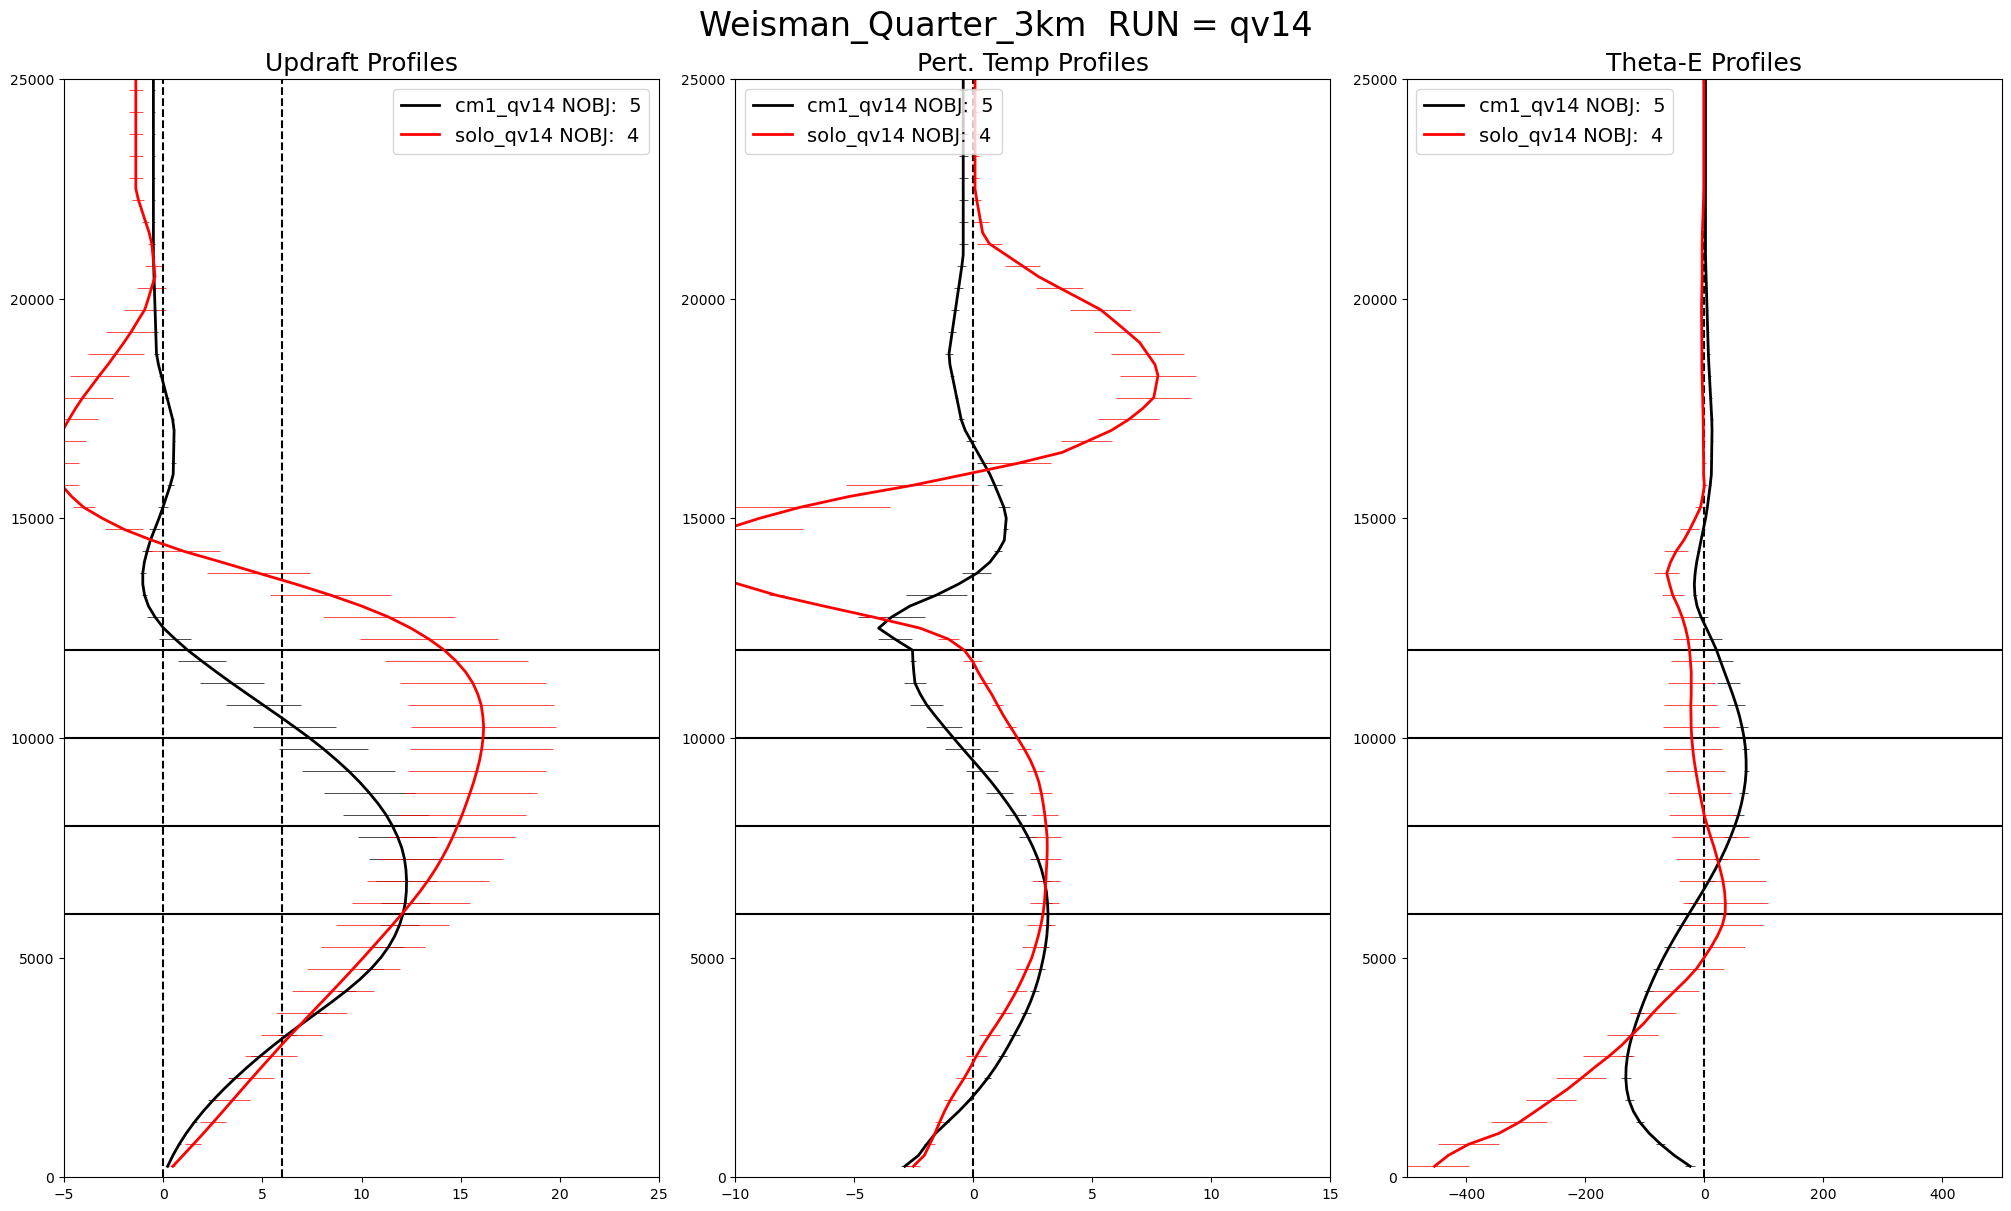

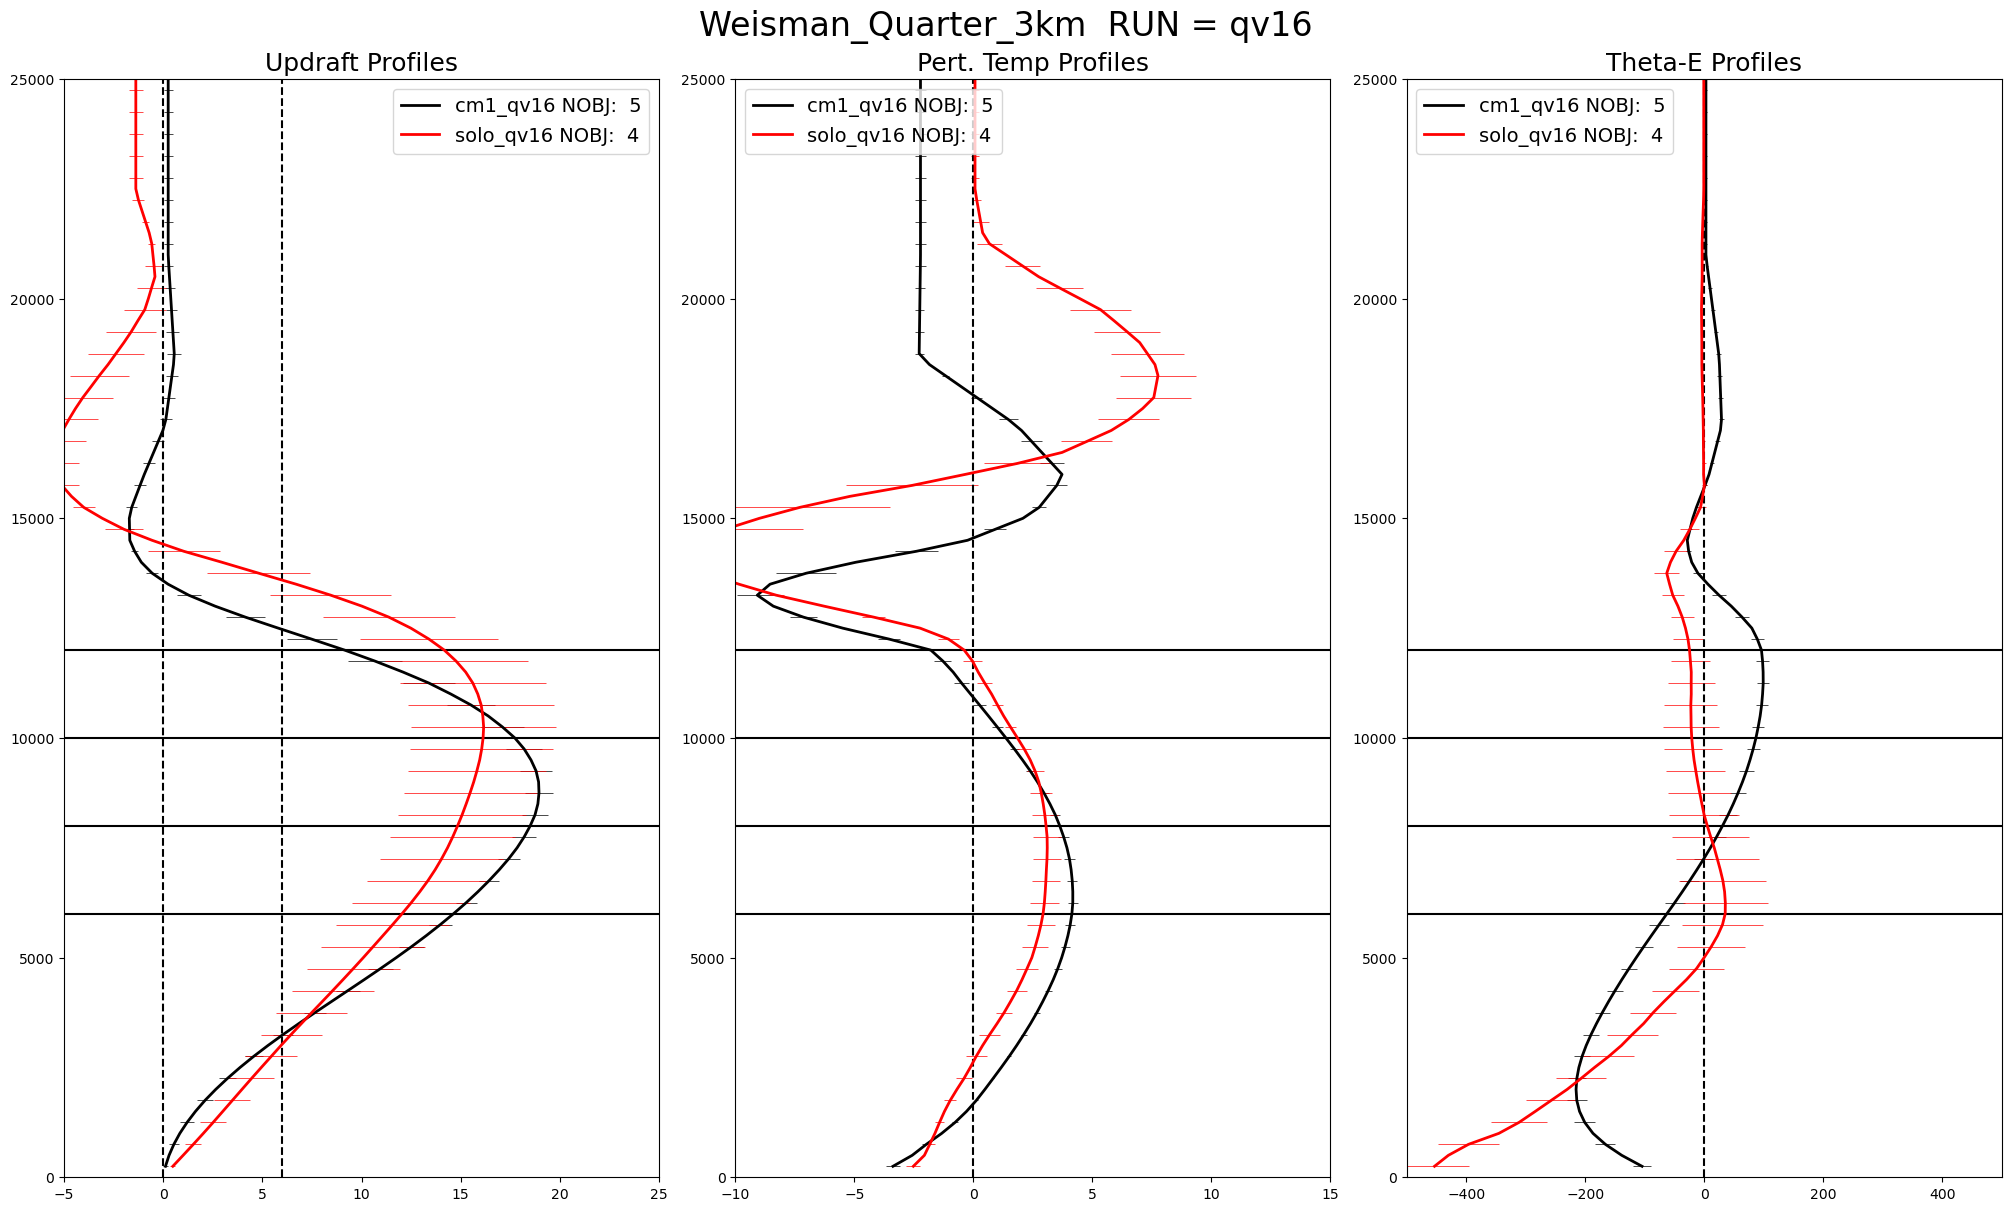

In [73]:
# Just read stuff back in...
            
plot_wptpth_driver( {'cm1': pickle2Obj('cm1_weisman_3km_profiles.pkl', retObj=False),
                     'solo': pickle2Obj('solo_weisman_3km_profiles.pkl', retObj=False)}, 
                    experiments = None, plot_label = 'Weisman_Quarter_3km' )

# plot_wptpth_driver( pickle2Obj('solo_weisman_newpsolver_profiles.pkl', retObj=False), 
#                     pickle2Obj('wrf_supercell_3km_profiles.pkl', retObj=False),
#                     pickle2Obj('solo_weisman_bench_profiles.pkl',retObj=False), plabel = 'supercell_3km' )


# # Just read stuff back in...
            
# plot_wprofile_driver( pickle2Obj('cm1_squall_noload_profiles.pkl',retObj=False), 
#                       pickle2Obj('wrf_squall_noload_profiles.pkl',retObj=False),
#                       pickle2Obj('solo_squall_3km_profiles.pkl',retObj=False), plabel = 'squall_NoLoad' )

In [32]:
#----------------------------------------------------
def plot_sizes_driver(cm1, wrf, solo, plabel=""):
    
    titles = ["0-2 Hour Updraft Sizes", "2-4 Hour Updraft Sizes", "4-6 Hour Updraft Sizes"]

    allcape = ( "qv16", )
    
    step = [[0,36],[12,24],[24,36]]

    for cape in allcape:

        label = "%s" % (cape)

        fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(20,10))

        for n, s in enumerate(step):

            t0 = solo[label]['tindex'][s[0]]
            t1 = solo[label]['tindex'][s[1]]
            ss = np.sort(solo[label]['size'][t0:t1])

            t0 = wrf[label]['tindex'][s[0]]
            t1 = wrf[label]['tindex'][s[1]]
            ww = np.sort(wrf[label]['size'][t0:t1])

            t0 = cm1[label]['tindex'][s[0]]
            t1 = cm1[label]['tindex'][s[1]]
            cc = np.sort(cm1[label]['size'][t0:t1])               

            zsolo = np.arange(len(ss))/float(len(ss))

            zwrf = np.arange(len(ww))/float(len(ww))

            zcm1 = np.arange(len(cc))/float(len(cc))

            ax[n].plot(ss, zsolo, color='r', label='FV3_SOLO')
            ax[n].plot(ww, zwrf, color='k', label='WRF')

            ax[n].plot(cc, zcm1, color='b', label='CM1')

            ax[n].set_title("%s - (Updraft Size in Pixels)" % (titles[n]), fontsize=14)
            ax[n].axhline(y=0.5, color='k', linestyle='--')
            ax[n].axhline(y=0.9,  color='k', linestyle='--')

            ax[n].set_ylim(0.0,1.1)
            ax[n].set_xlim(0,80)
            ax[n].legend(fontsize=14, loc='lower right')

        plt.suptitle("%s" % (label), fontsize=18)


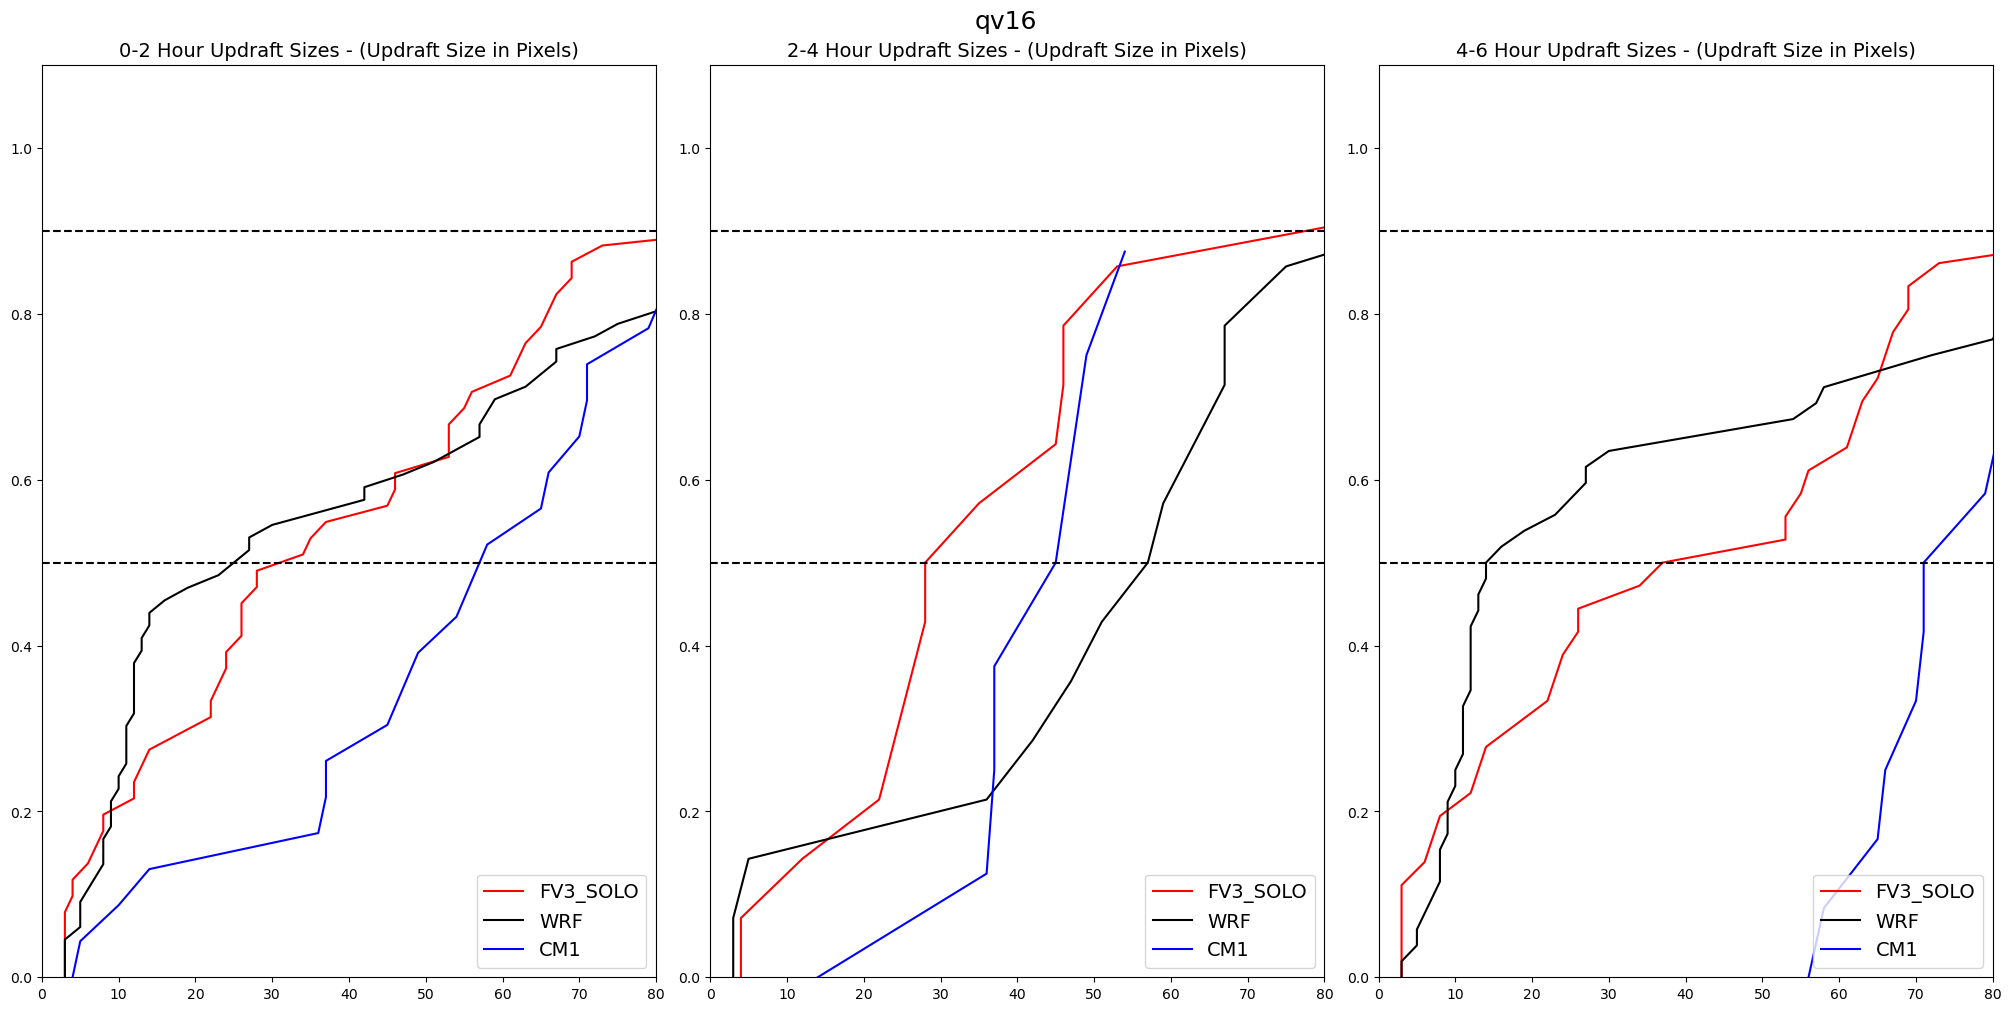

In [33]:

# # Just read stuff back in...
            
plot_sizes_driver( pickle2Obj('cm1_supercell_3km_profiles.pkl', retObj=False), 
                    pickle2Obj('wrf_supercell_3km_profiles.pkl', retObj=False),
                    pickle2Obj('solo_supercell_3km_profiles.pkl',retObj=False), plabel = 'supercell_3km' )


In [23]:
percentile = 0.998

path = "/work/wicker/WRF/WRF/test/em_quarter_ss/supercell_3km_qv16"
# with open(os.path.join(path, 'dbz.npz'), 'rb') as f:
#     dbz = np.load(f)

ds = tools.WRF_tools.read_wrf_fields(path, file_pattern=None, vars=['qr', 'w',], ret_dbz=True)

print(" WRF ")
wrf_value = get_percentile_value(ds['qr'].max(axis=1), percentile=percentile)
wrf_value = get_percentile_value(ds['w'],  percentile=percentile)
wrf_value = get_percentile_value(ds['dbz'].max(axis=1),  percentile=percentile)


path = "/work/wicker/Odin_scr/cm1r20.3/run/supercell_3km_qv16"
# with open(os.path.join(path, 'dbz.npz'), 'rb') as f:
#     dbz = np.load(f)
    
ds = tools.CM1_tools.read_cm1_fields(path, file_pattern=None, vars=['qr', 'w',], ret_dbz=True)
print(" CM1 ")
cm1_value = get_percentile_value(ds['qr'].max(axis=1), percentile=percentile)
cm1_value = get_percentile_value(ds['w'],  percentile=percentile)
cm1_value = get_percentile_value(ds['dbz'].max(axis=1),  percentile=percentile)

path = "/work/wicker/Odin_scr/solo/supercell_3km_qv16"

# with open(os.path.join(path, 'dbz.npz'), 'rb') as f:
#     dbz = np.load(f)
    
ds = tools.FV3_tools.read_solo_fields(path, file_pattern=None, vars=['qr', 'w',], ret_dbz=True)
print(" SOLO ")
wrf_value = get_percentile_value(ds['qr'].max(axis=1), percentile=percentile)
wrf_value = get_percentile_value(ds['w'],  percentile=percentile)
wrf_value = get_percentile_value(ds['dbz'].max(axis=1),  percentile=percentile)



------------------------------------------------------------------------------------------------------------------------ 

 Added default filename to path input:  /work/wicker/WRF/WRF/test/em_quarter_ss/supercell_3km_qv16/wrfout_d01_0001-01-01_00:00:00
------------------------------------------------------------------------------------------------------------------------ 

 Reading:  /work/wicker/WRF/WRF/test/em_quarter_ss/supercell_3km_qv16/wrfout_d01_0001-01-01_00:00:00 


 Reading external DBZ file: /work/wicker/WRF/WRF/test/em_quarter_ss/supercell_3km_qv16/dbz.npz

 Completed reading in:  /work/wicker/WRF/WRF/test/em_quarter_ss/supercell_3km_qv16/wrfout_d01_0001-01-01_00:00:00 

------------------------------------------------------------------------------------------------------------------------
 WRF 

 Percentile:  0.998000  Index:  2401113   Value:  0.005385

 Percentile:  0.998000  Index:  144066789   Value:  1.407902

 Percentile:  0.998000  Index:  2401113   Value:  56.24750

In [41]:
percentile = 0.9975

path = "/work/wicker/WRF/WRF/test/em_quarter_ss/squall_3km_C2000_12"
# with open(os.path.join(path, 'dbz.npz'), 'rb') as f:
#     dbz = np.load(f)
    
ds = tools.WRF_tools.read_wrf_fields(path, file_pattern=None, vars=['w',], ret_dbz=True)
print("WRF")
cm1_value = get_percentile_value(ds['w'].max(axis=1),  percentile=percentile)
cm1_value = get_percentile_value(ds['dbz'].max(axis=1),  percentile=percentile)

------------------------------------------------------------------------------------------------------------------------ 

 Added default filename to path input:  /work/wicker/WRF/WRF/test/em_quarter_ss/squall_3km_C2000_12/wrfout_d01_0001-01-01_00:00:00
------------------------------------------------------------------------------------------------------------------------ 

 Reading:  /work/wicker/WRF/WRF/test/em_quarter_ss/squall_3km_C2000_12/wrfout_d01_0001-01-01_00:00:00 


 Reading external DBZ file: /work/wicker/WRF/WRF/test/em_quarter_ss/squall_3km_C2000_12/dbz.npz

 Completed reading in:  /work/wicker/WRF/WRF/test/em_quarter_ss/squall_3km_C2000_12/wrfout_d01_0001-01-01_00:00:00 

------------------------------------------------------------------------------------------------------------------------
WRF

 Percentile:  0.997500  Index:  1621560   Value:  4.300099

 Percentile:  0.997500  Index:  1621560   Value:  51.555954


------------------------------------------------------------------------------------------------------------------------ 

 Reading:  /work/wicker/WRF/WRF/test/em_quarter_ss/supercell_3km_qv16/wrfout_d01_0001-01-01_00:00:00 


 Reading external DBZ file: /work/wicker/WRF/WRF/test/em_quarter_ss/supercell_3km_qv16/dbz.npz

 Completed reading in:  /work/wicker/WRF/WRF/test/em_quarter_ss/supercell_3km_qv16/wrfout_d01_0001-01-01_00:00:00 

------------------------------------------------------------------------------------------------------------------------
1


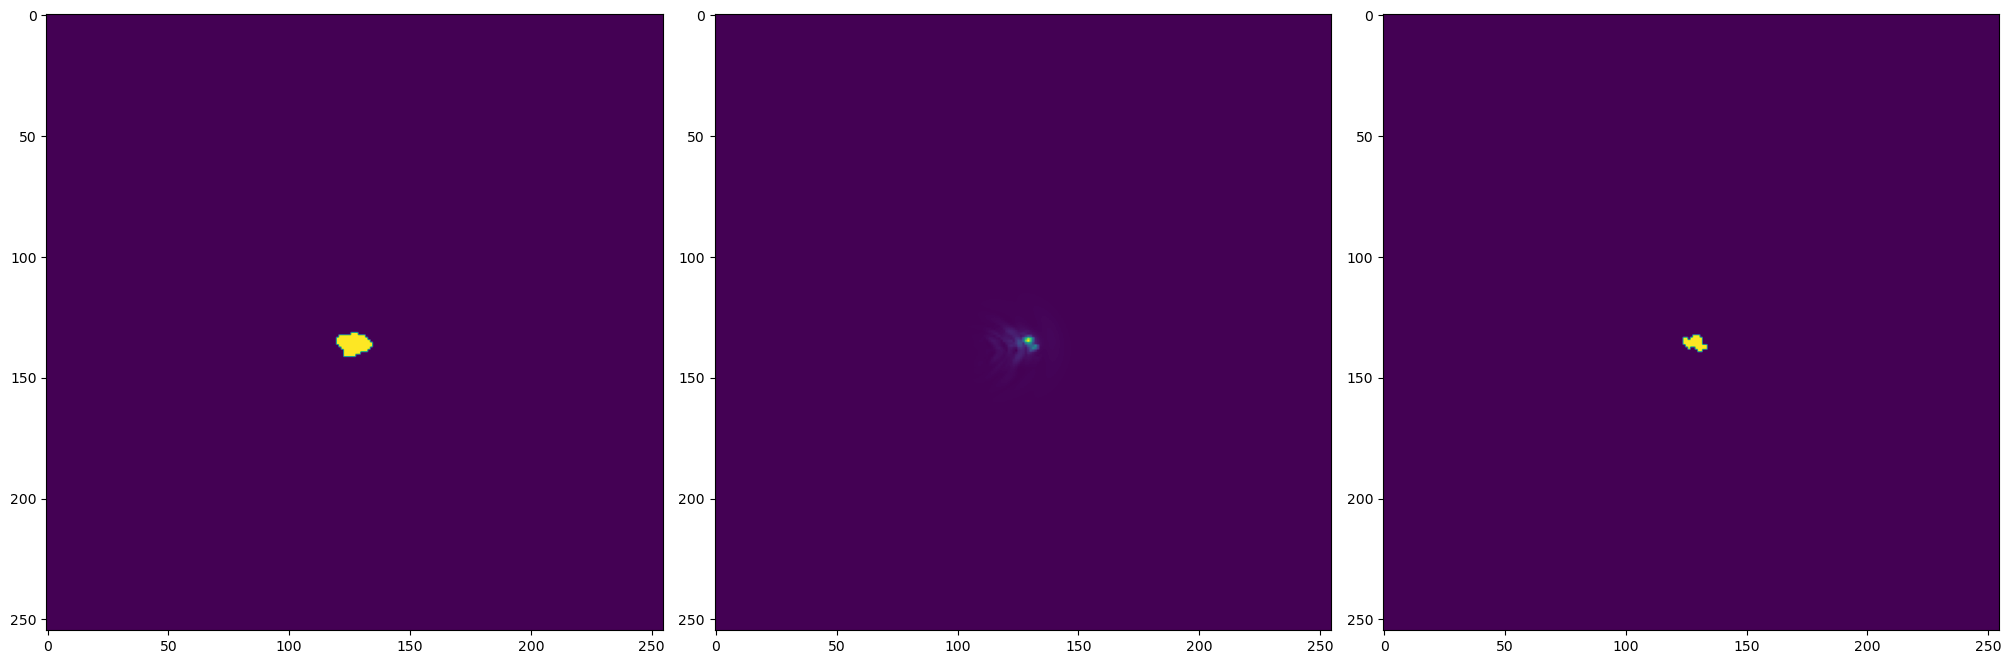

1


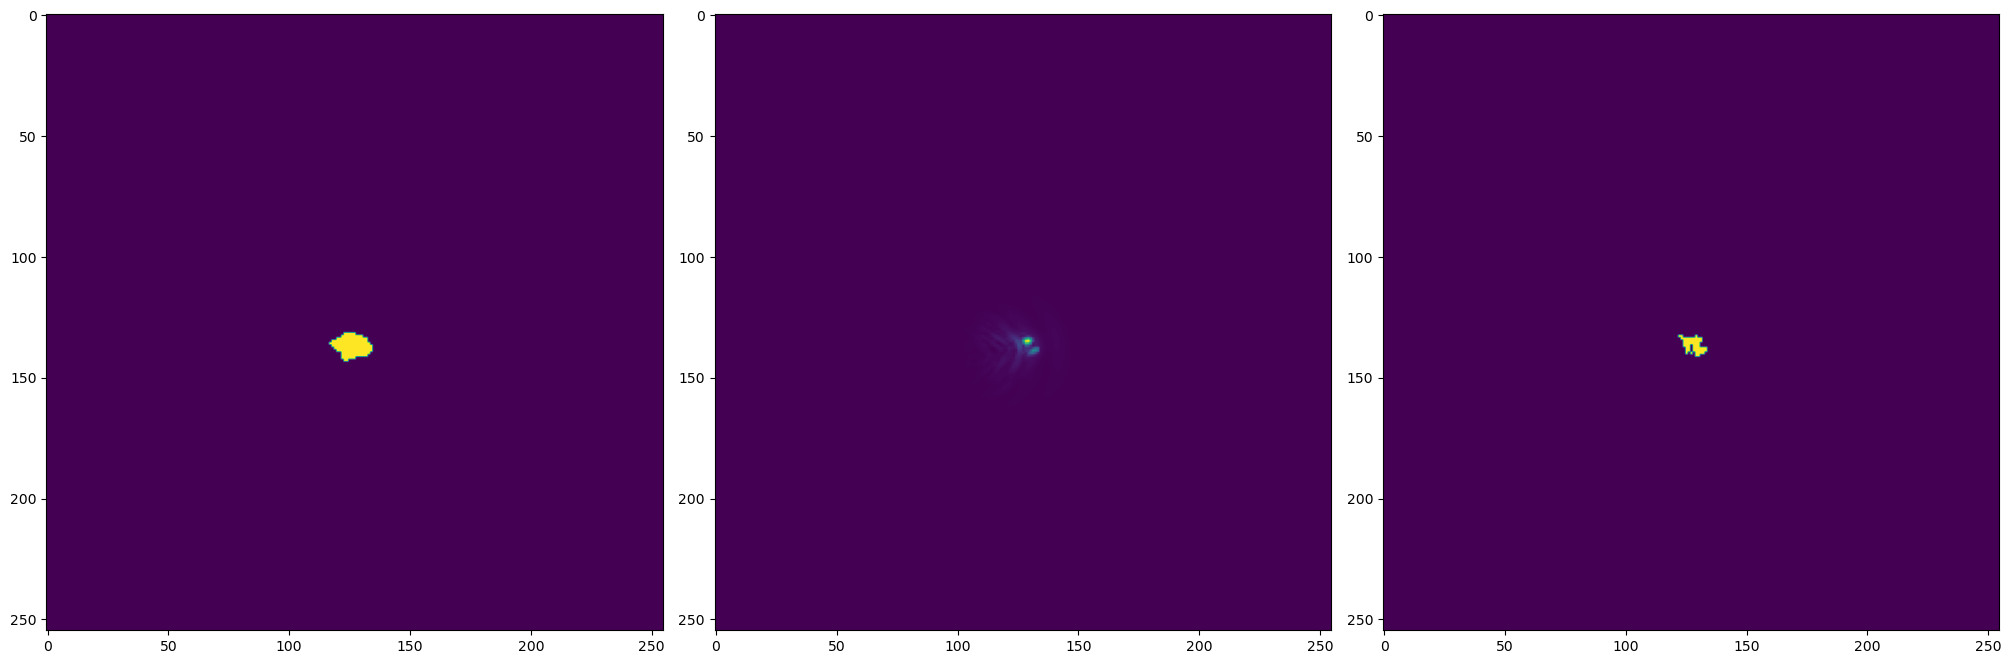

2


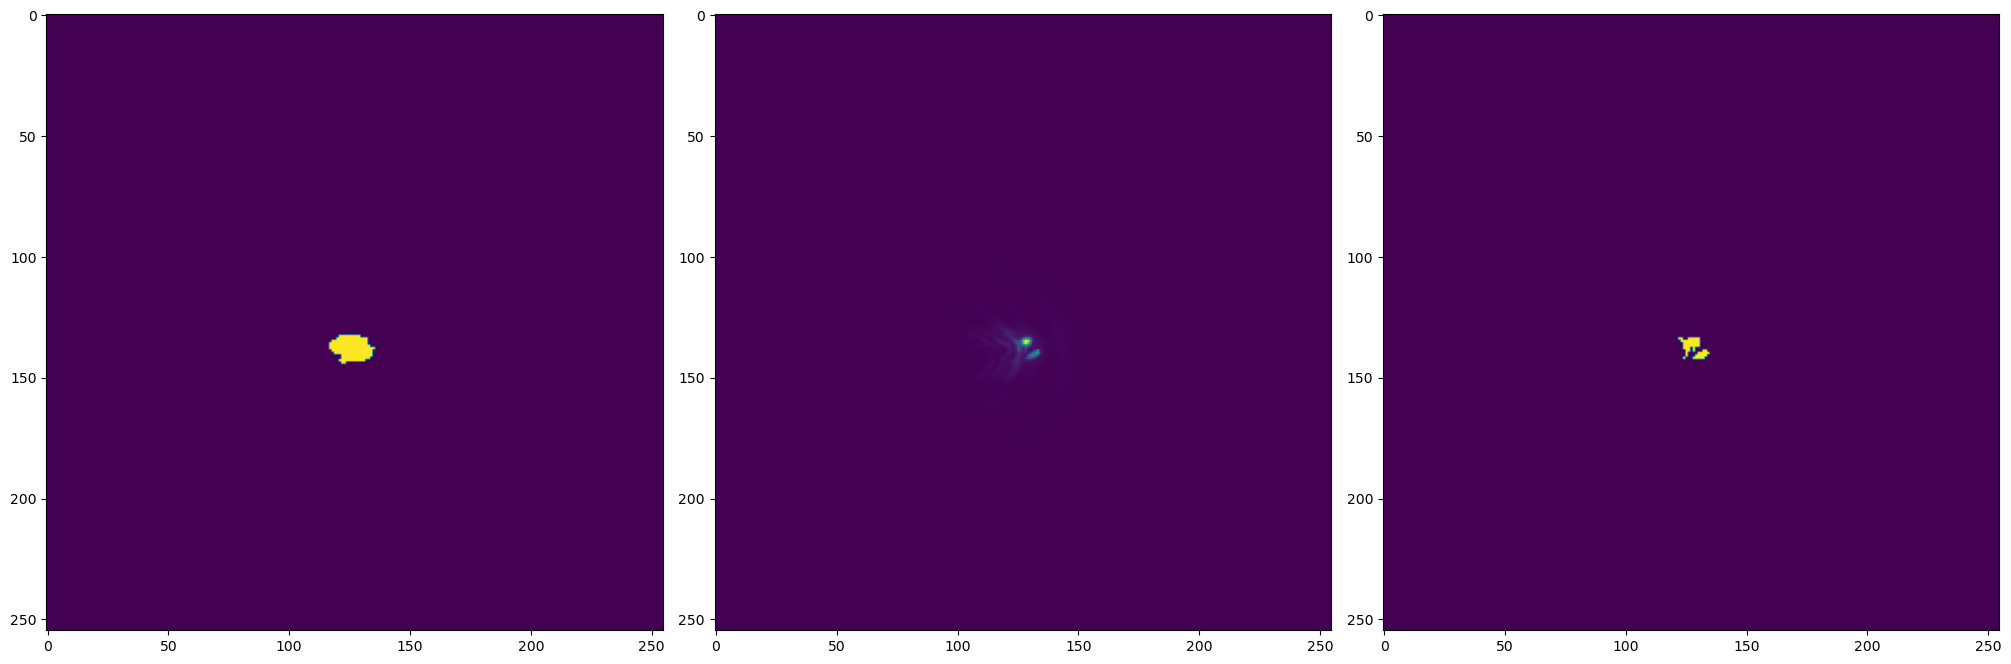

2


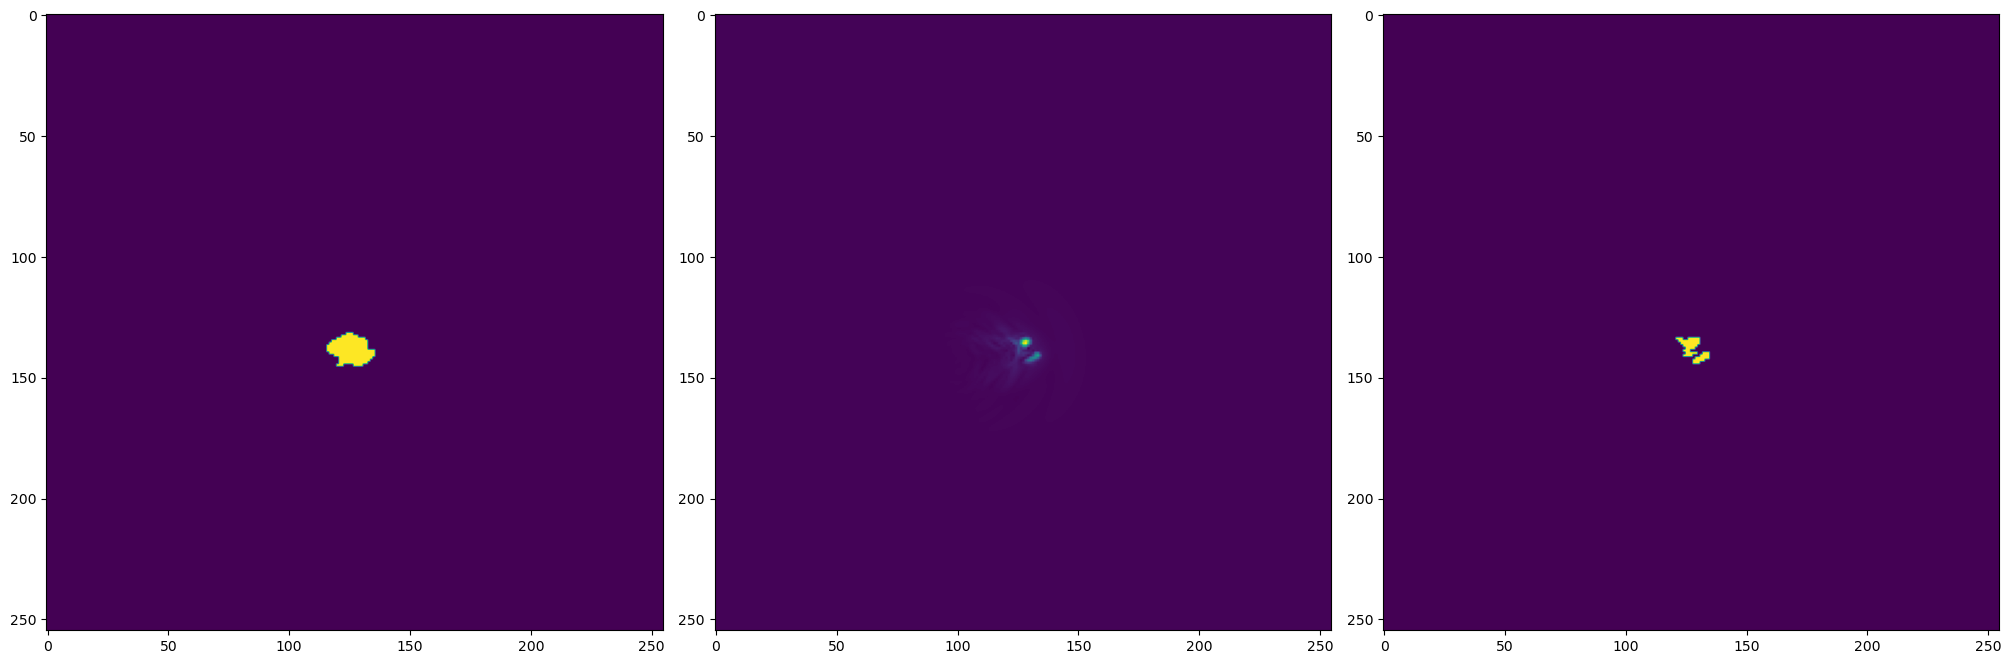

1


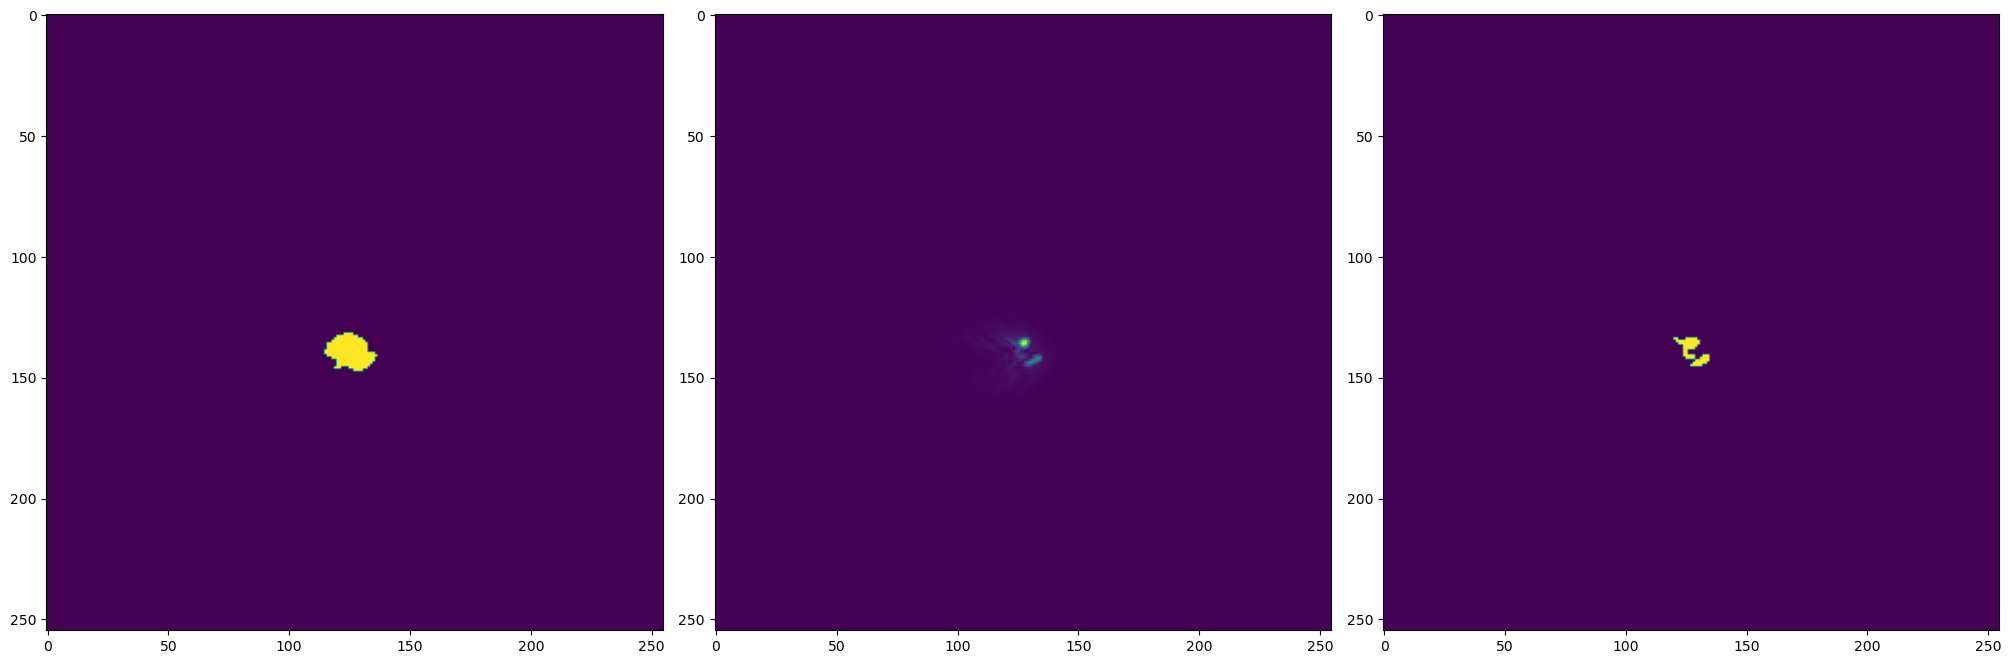

2


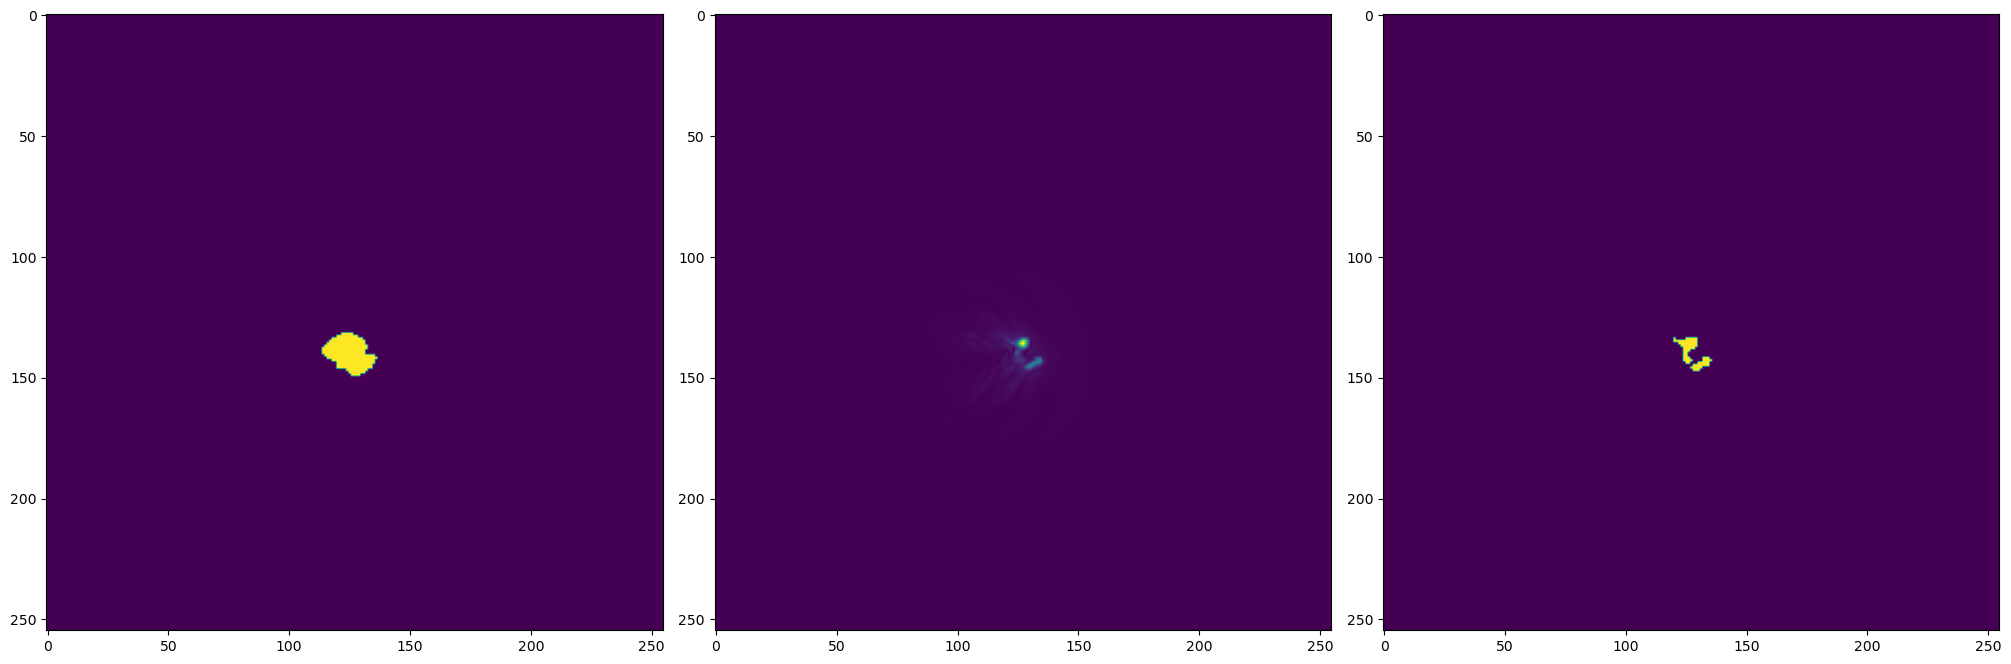

1


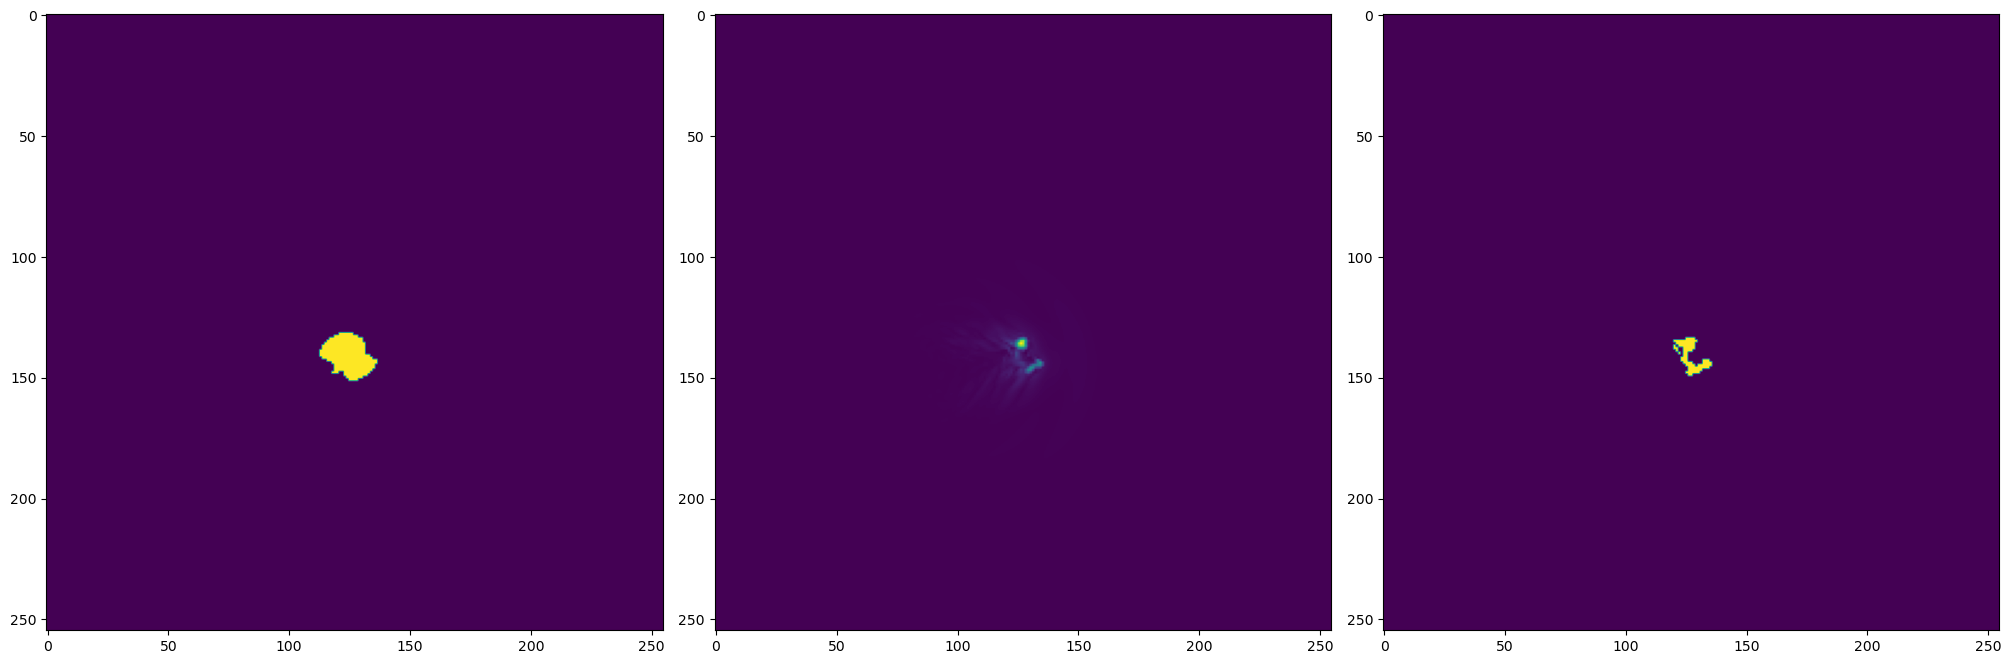

3


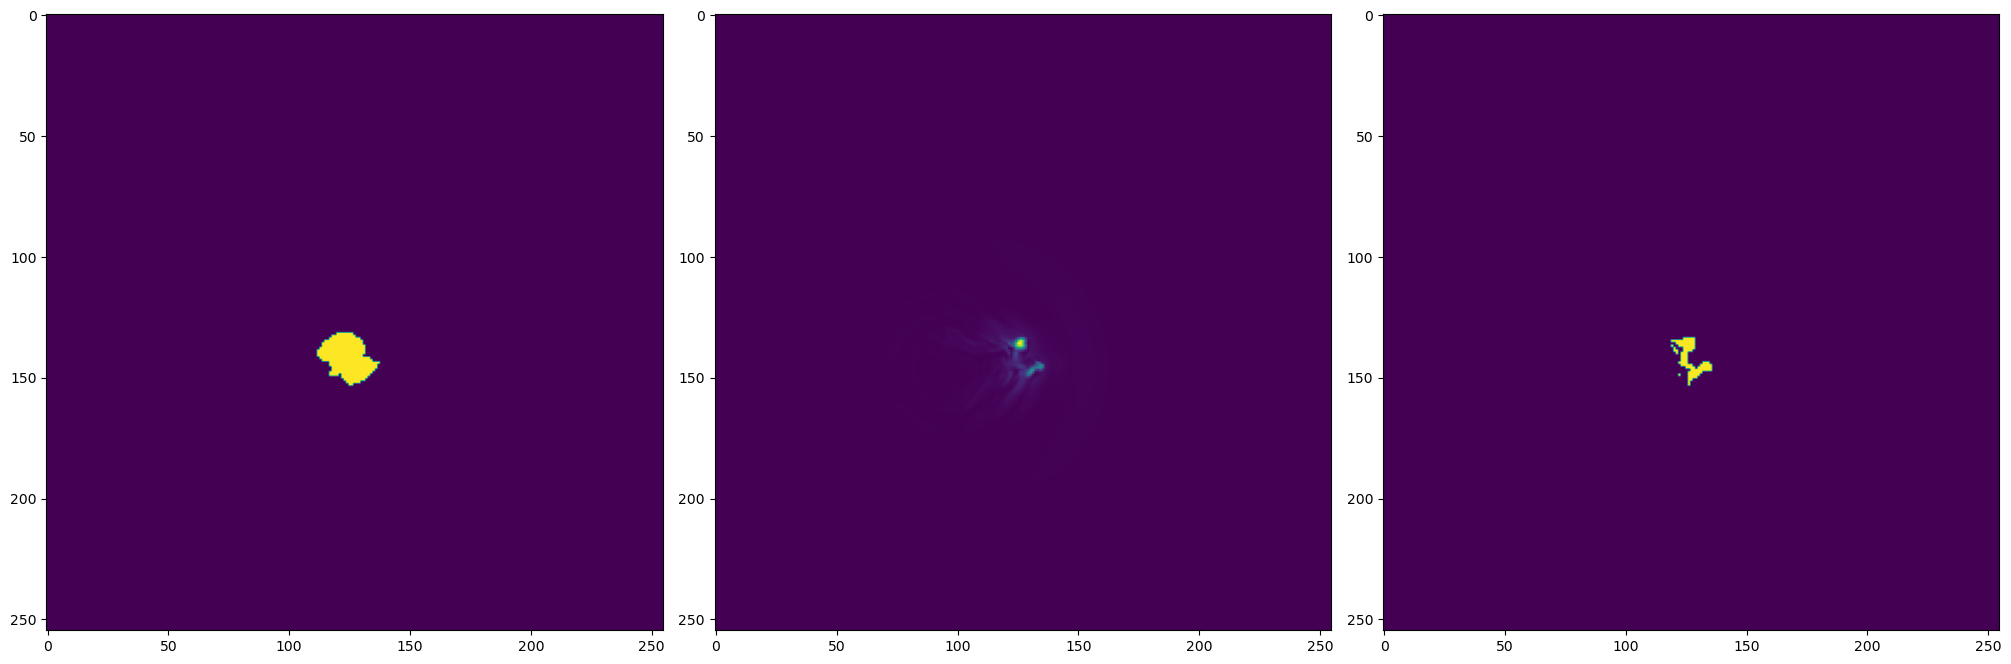

2


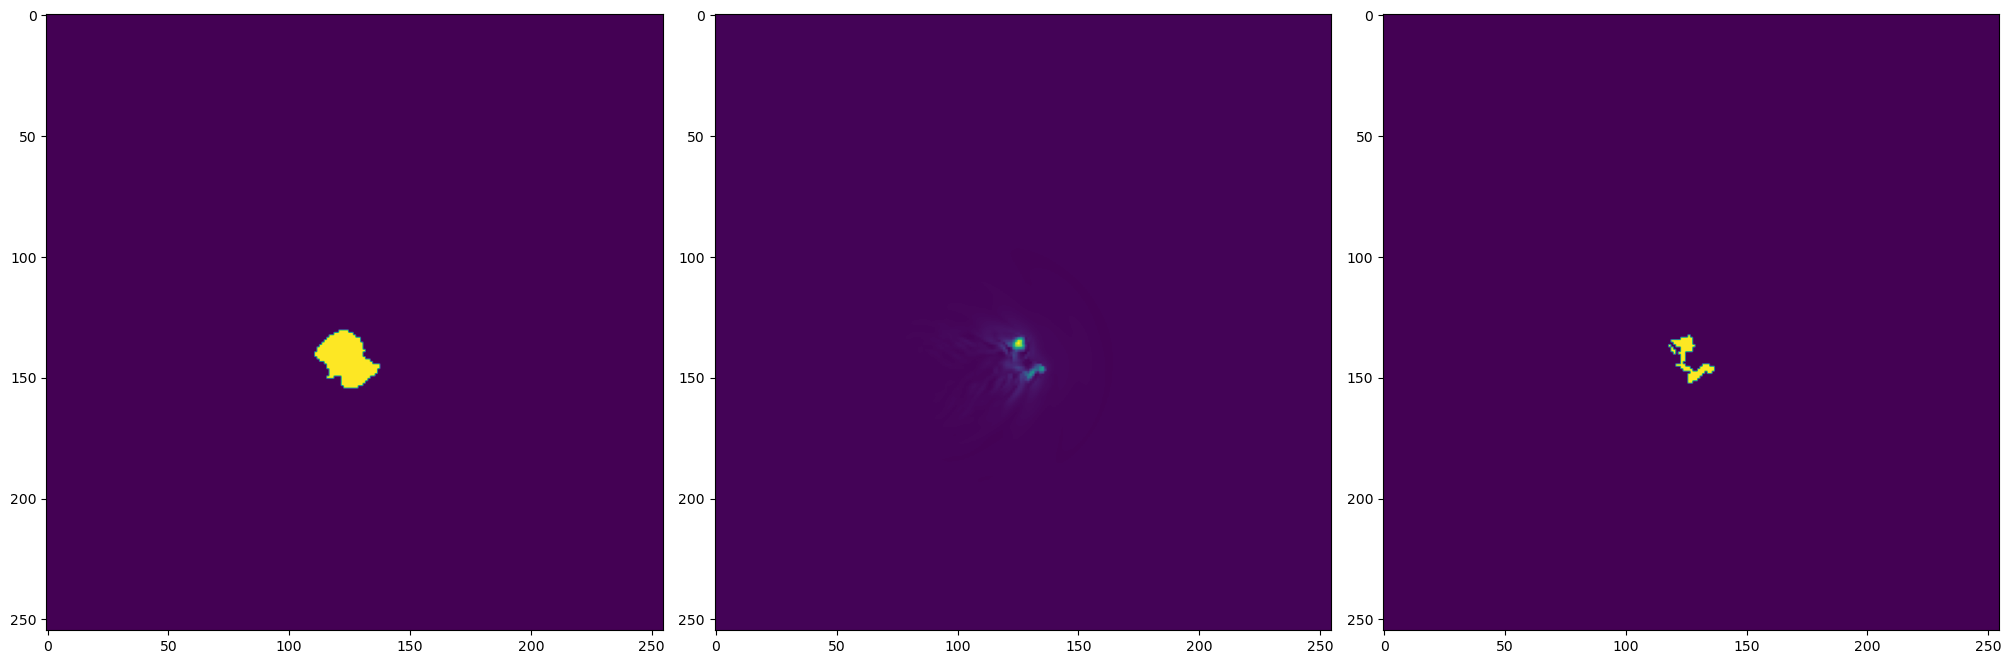

3


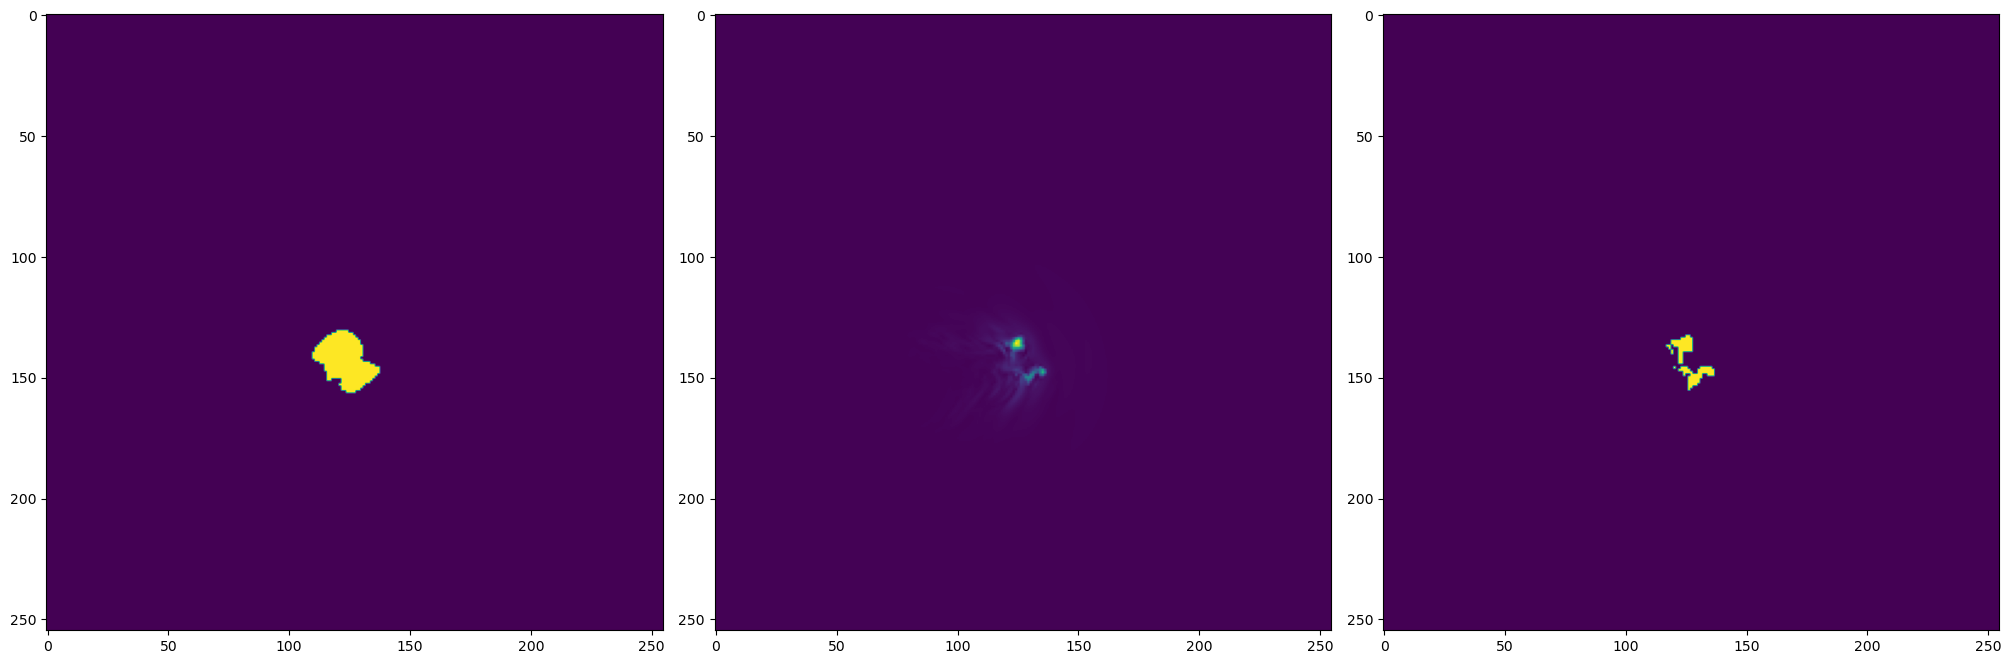

1


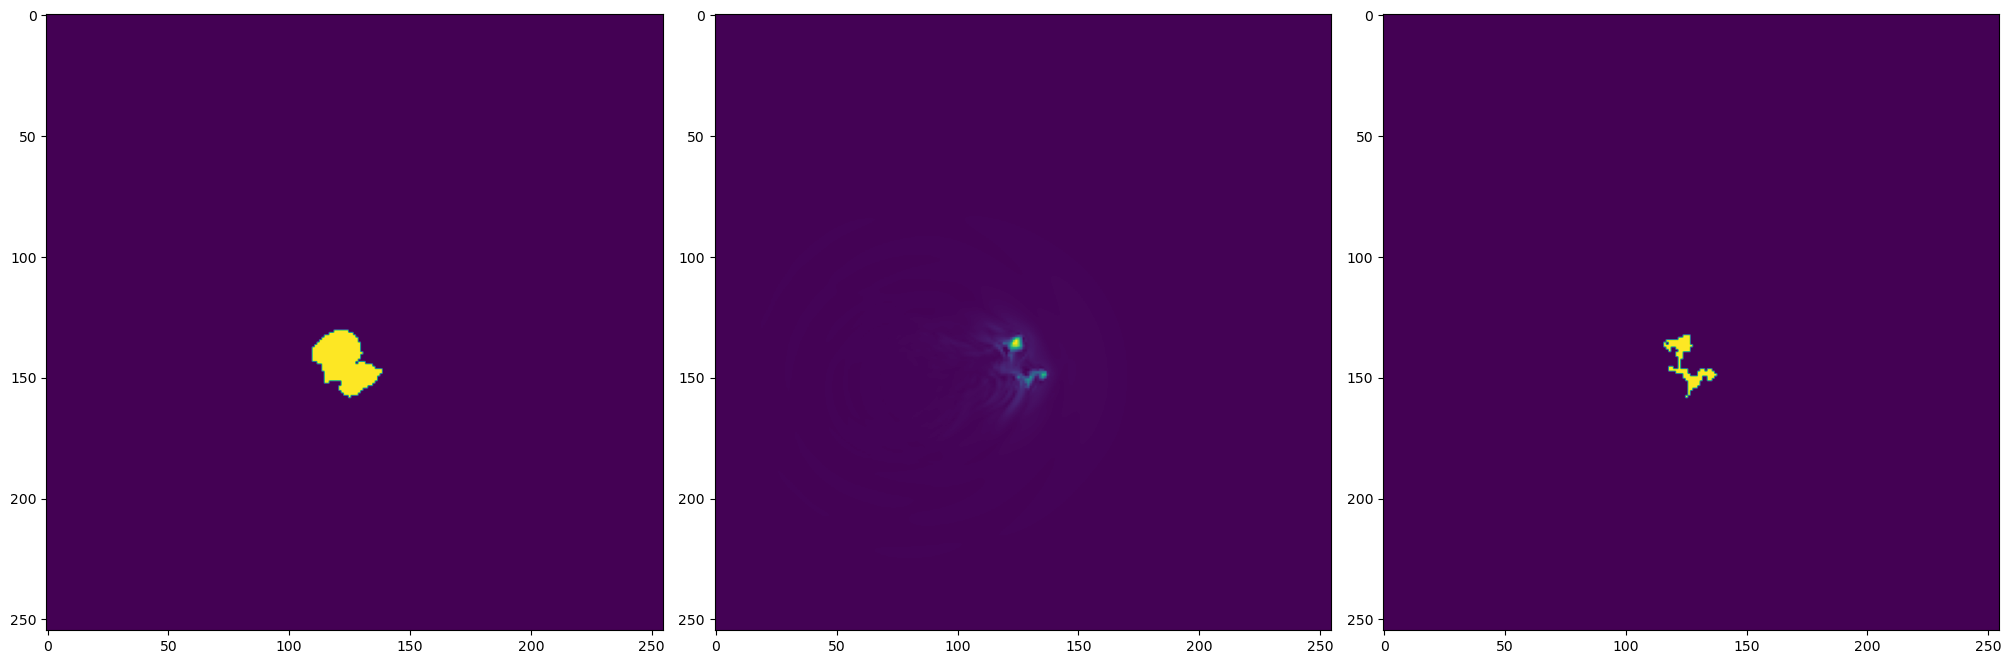

2


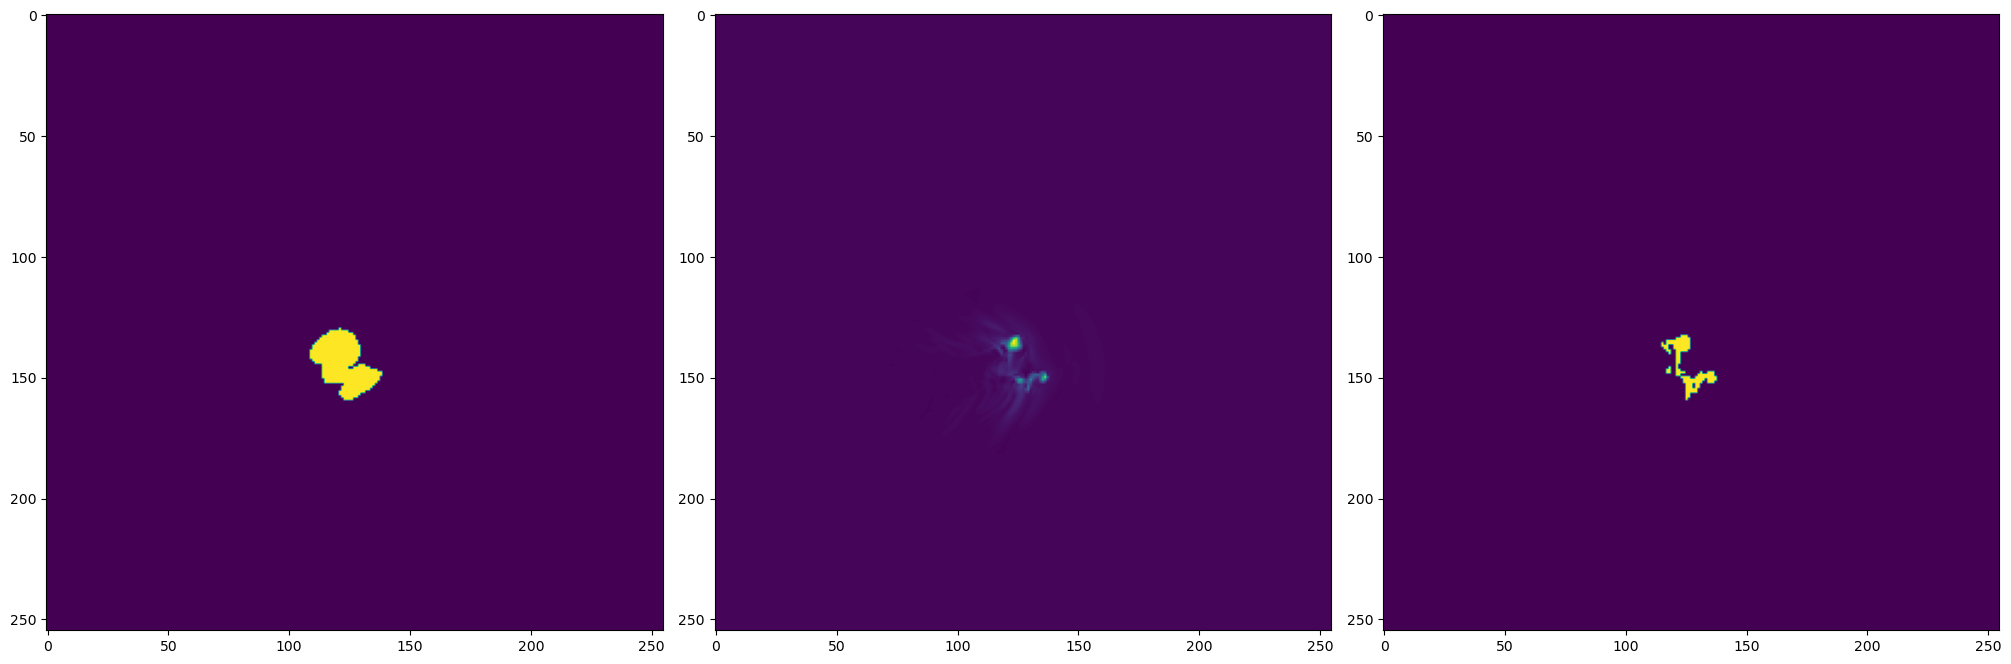

6


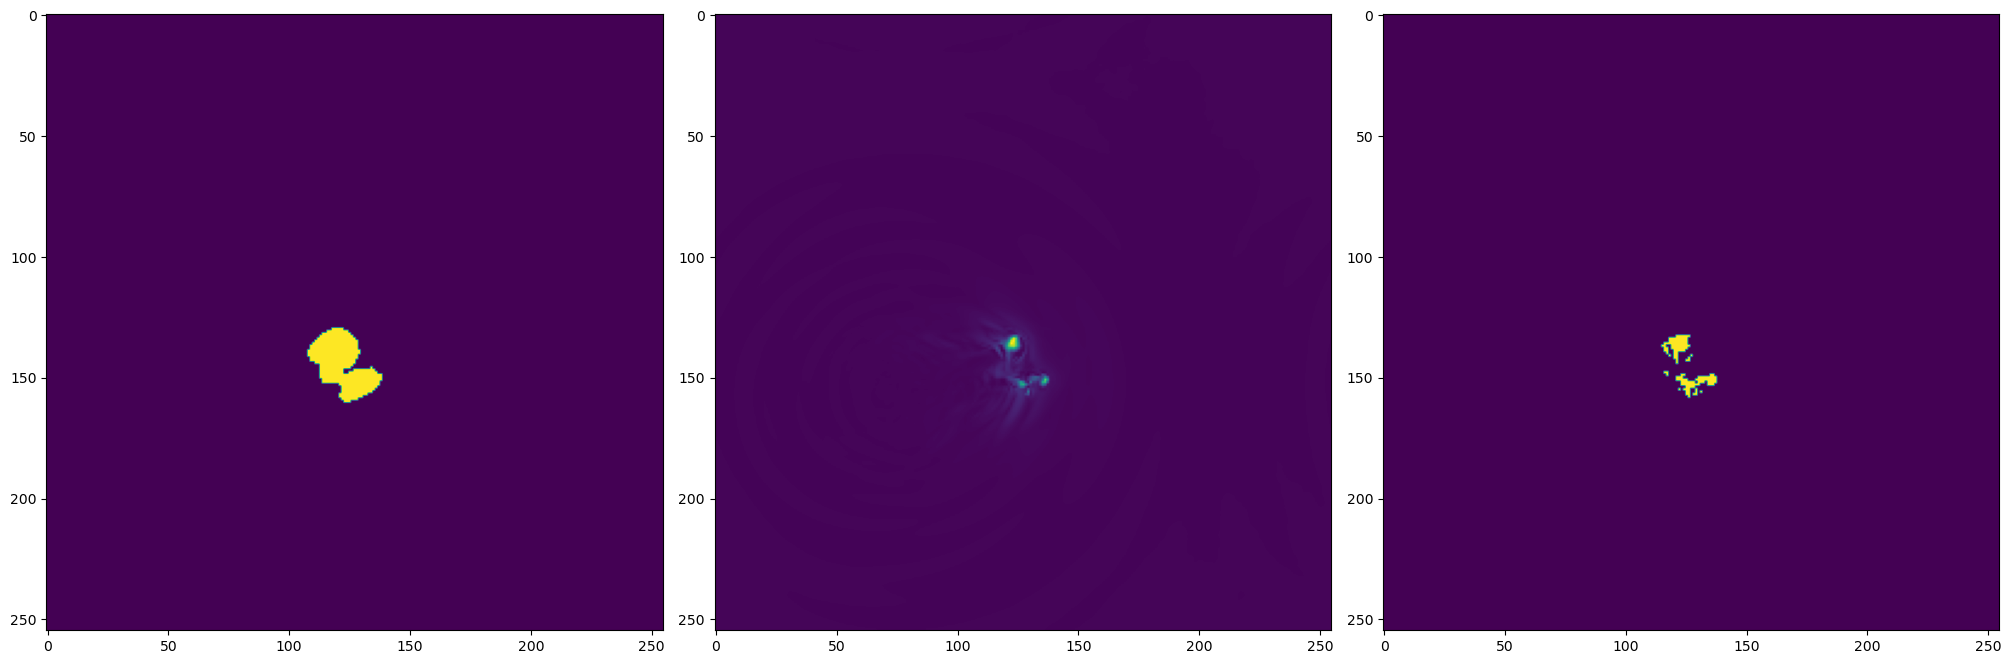

6


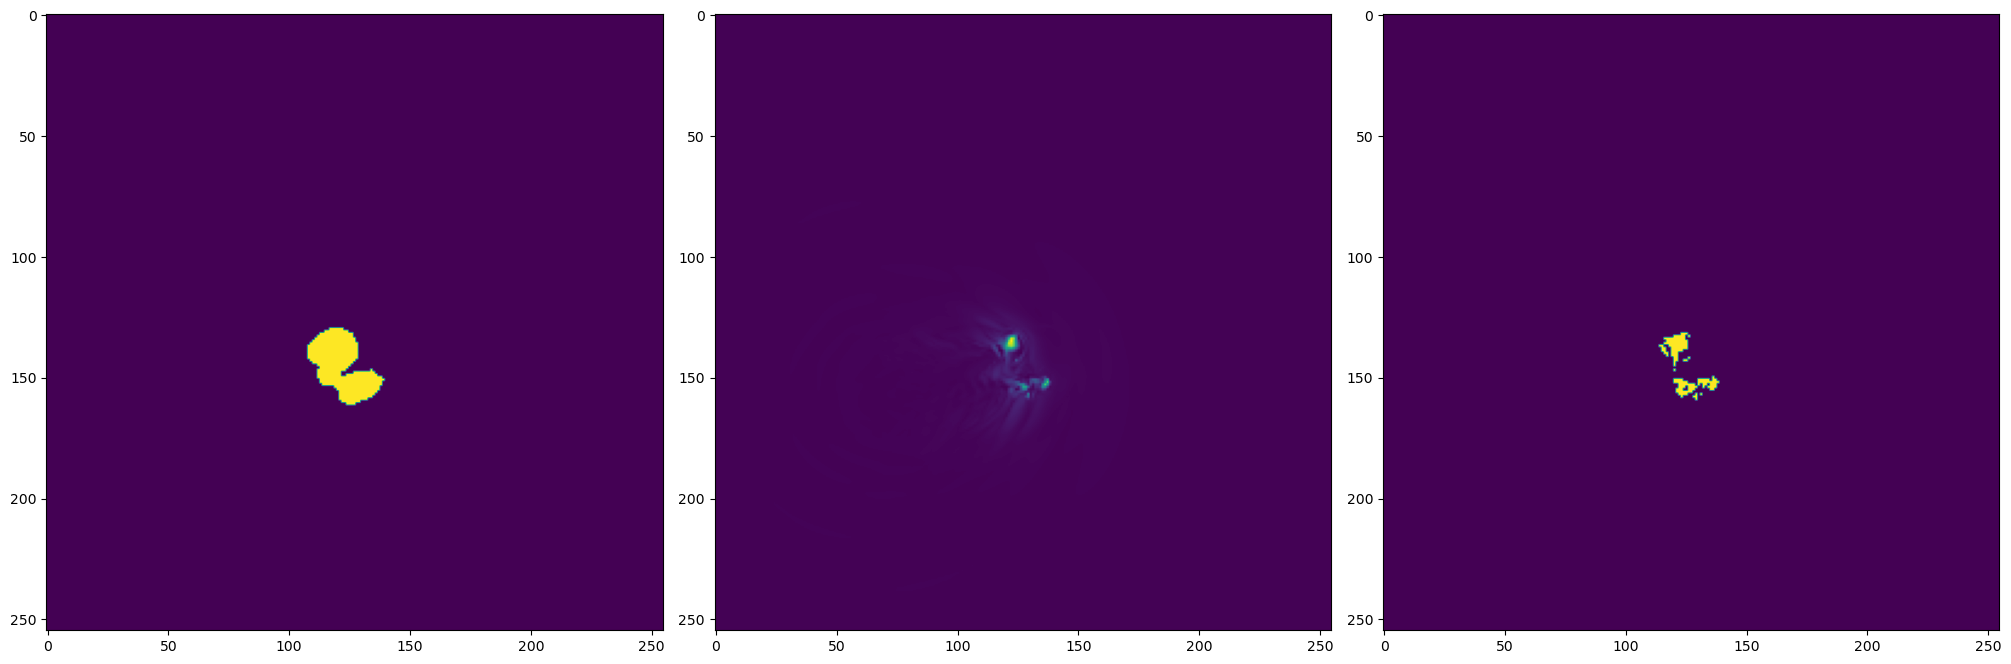

6


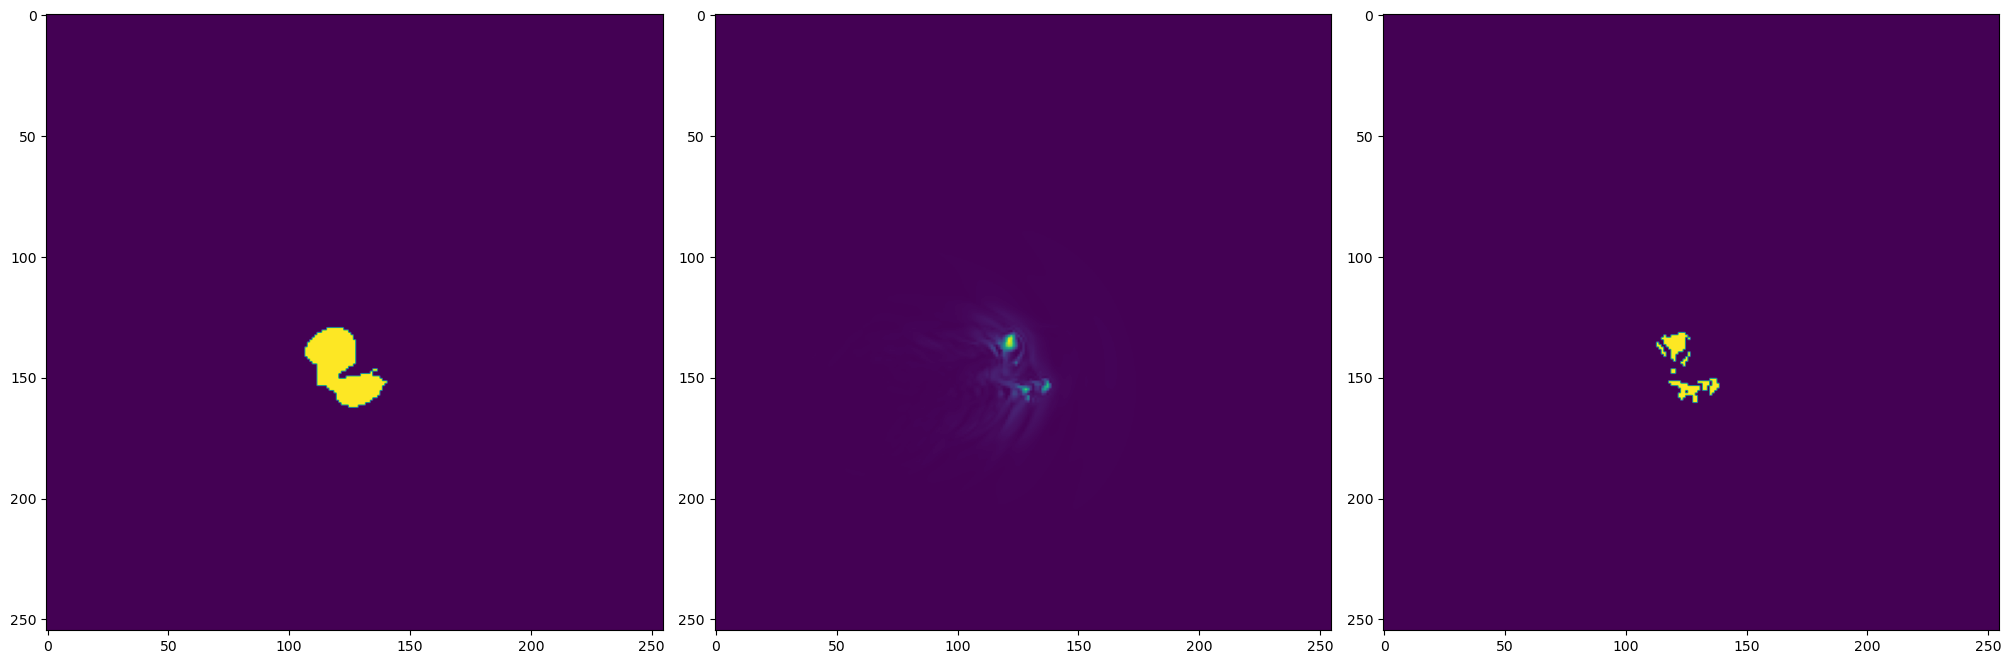

5


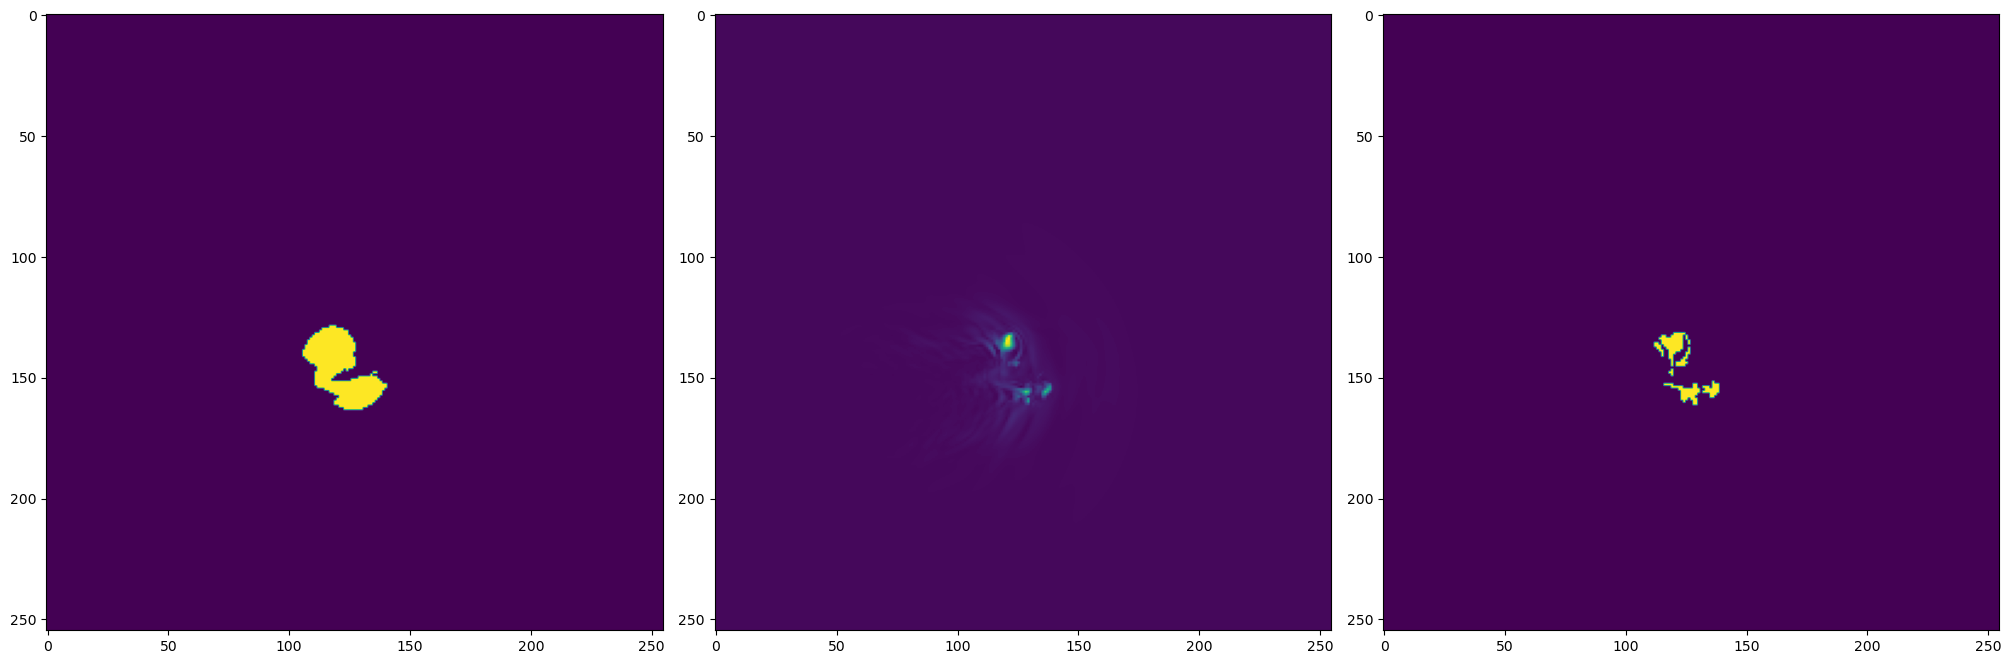

6


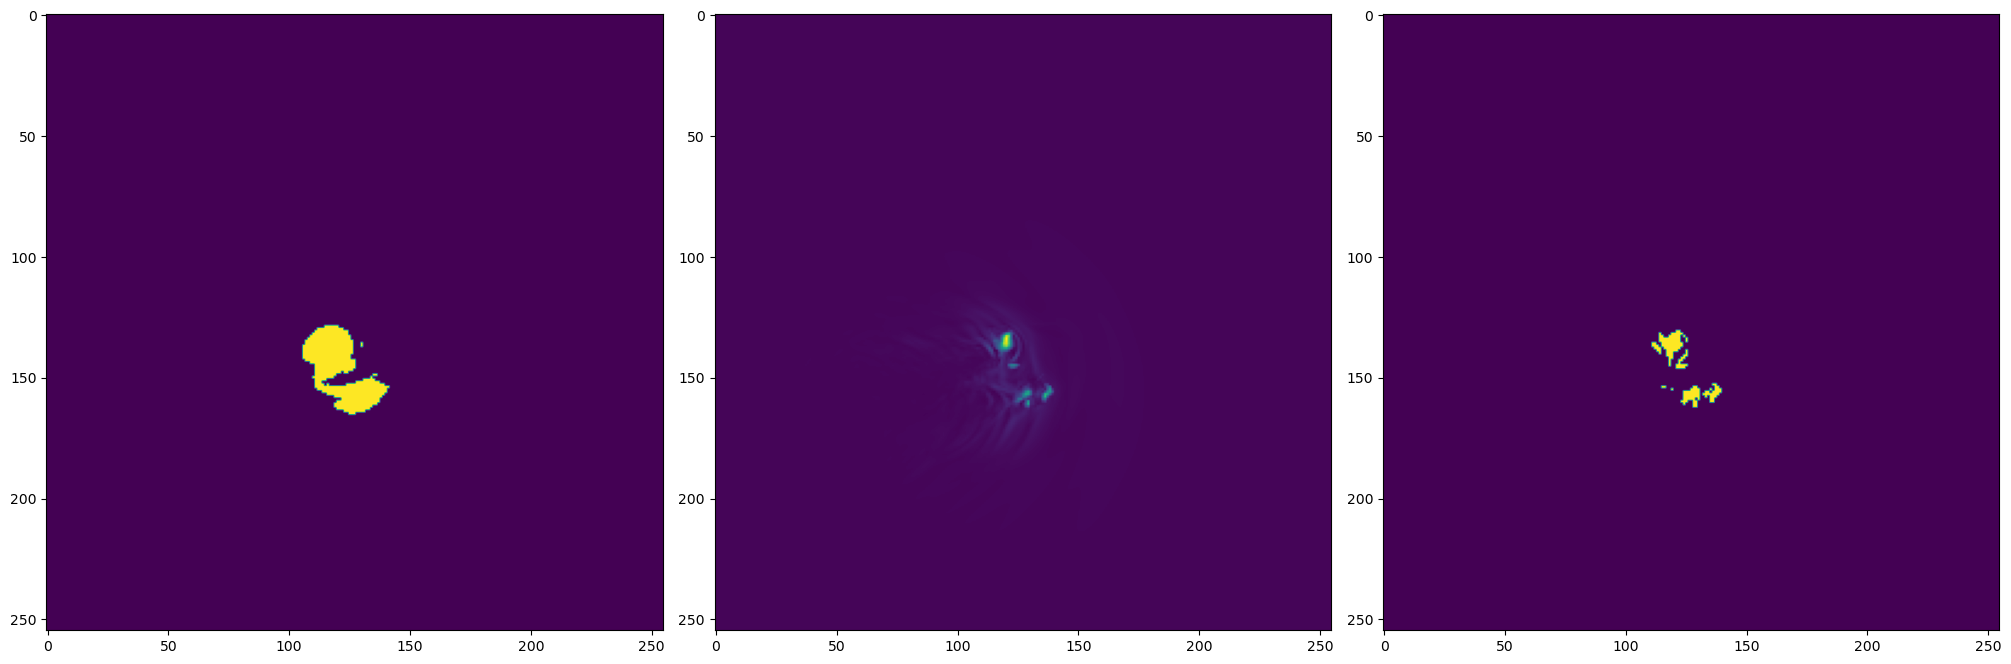

9


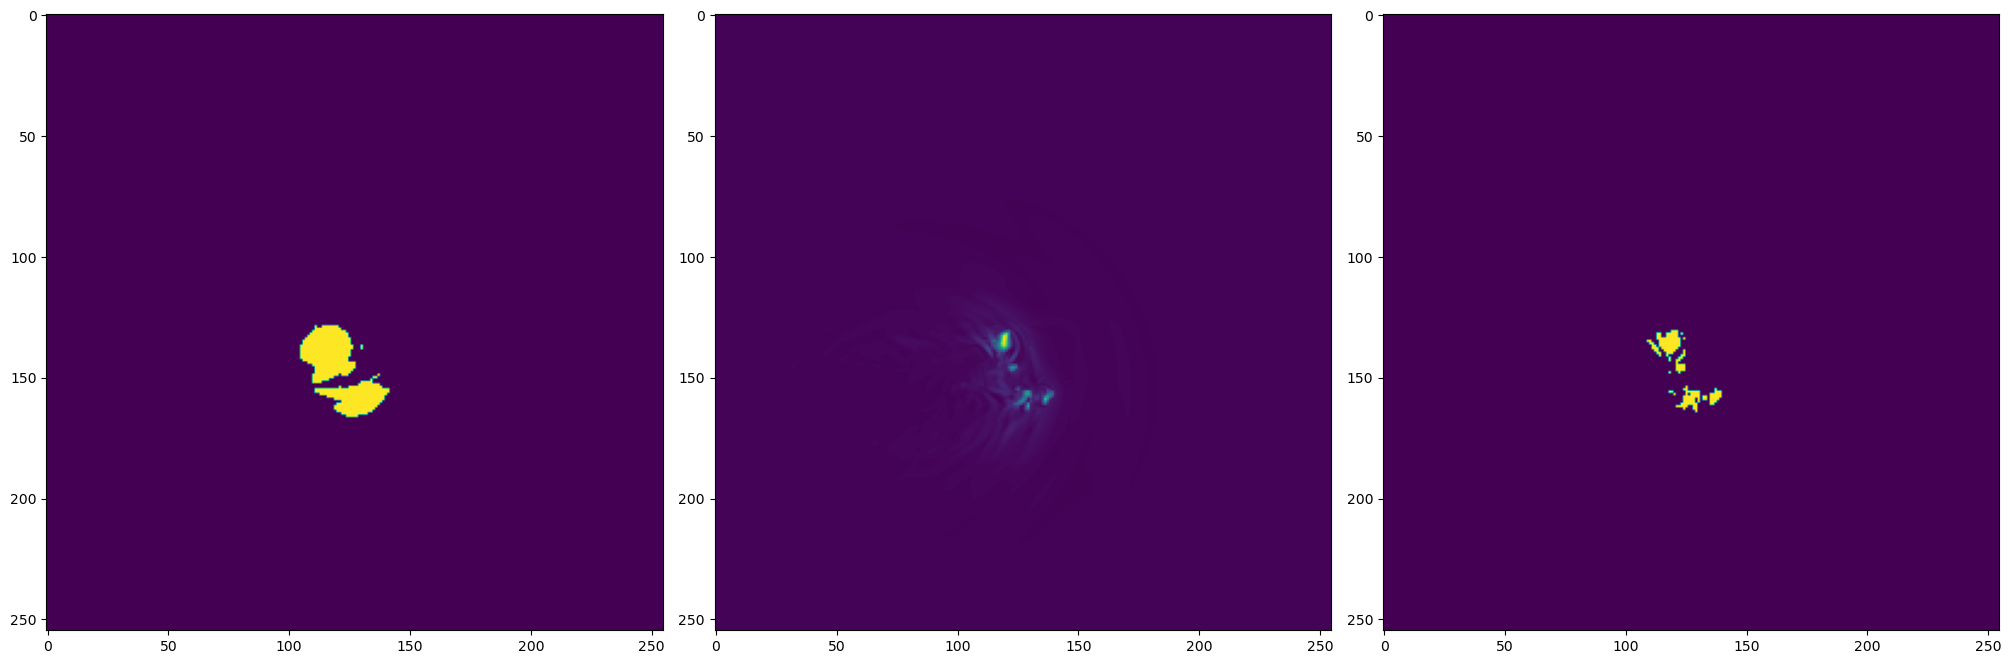

7


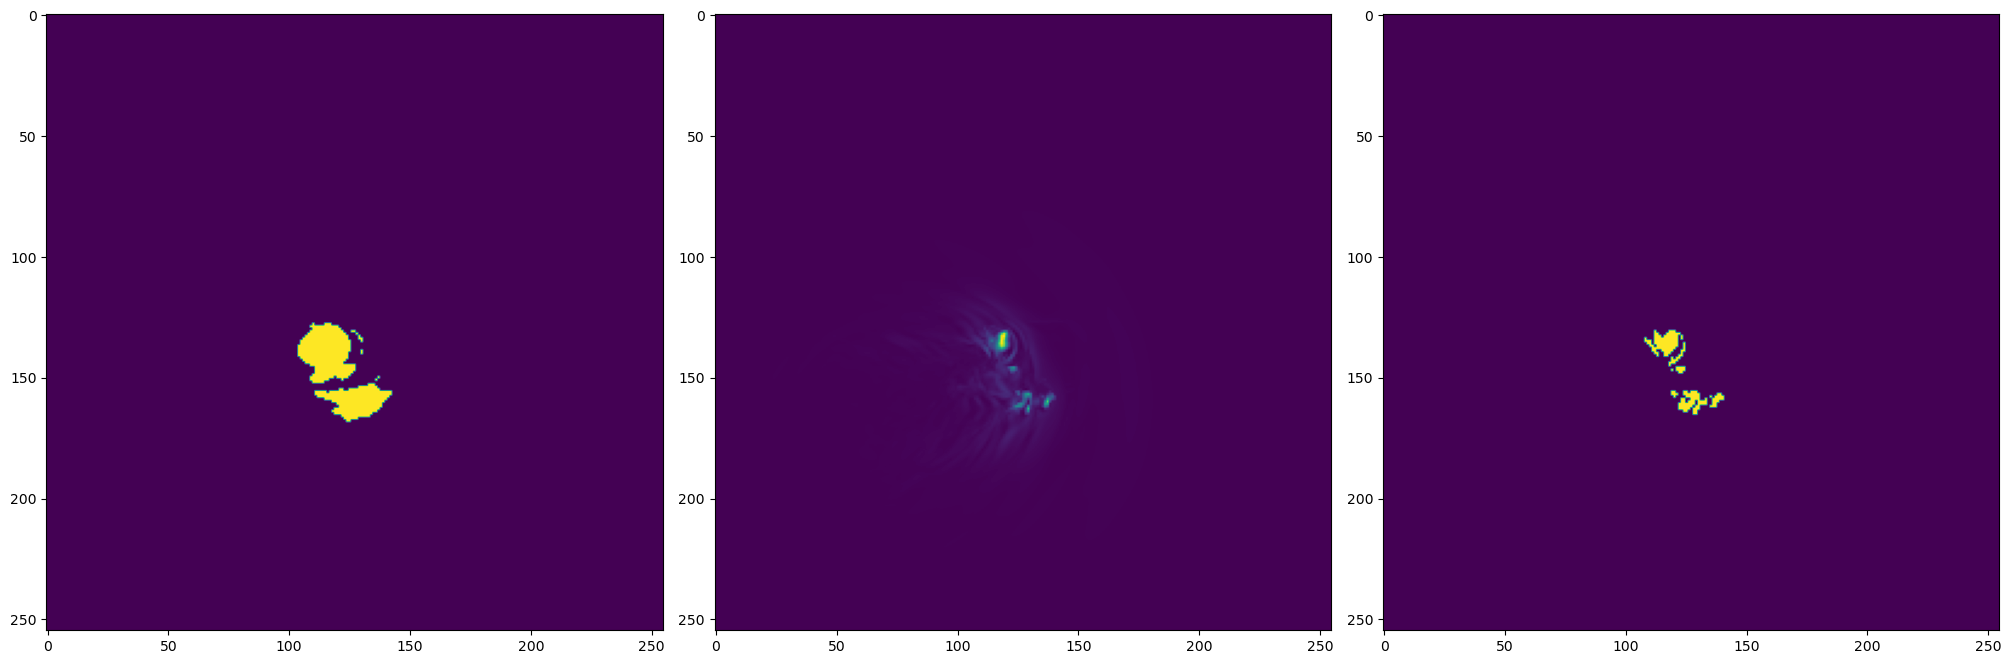

9


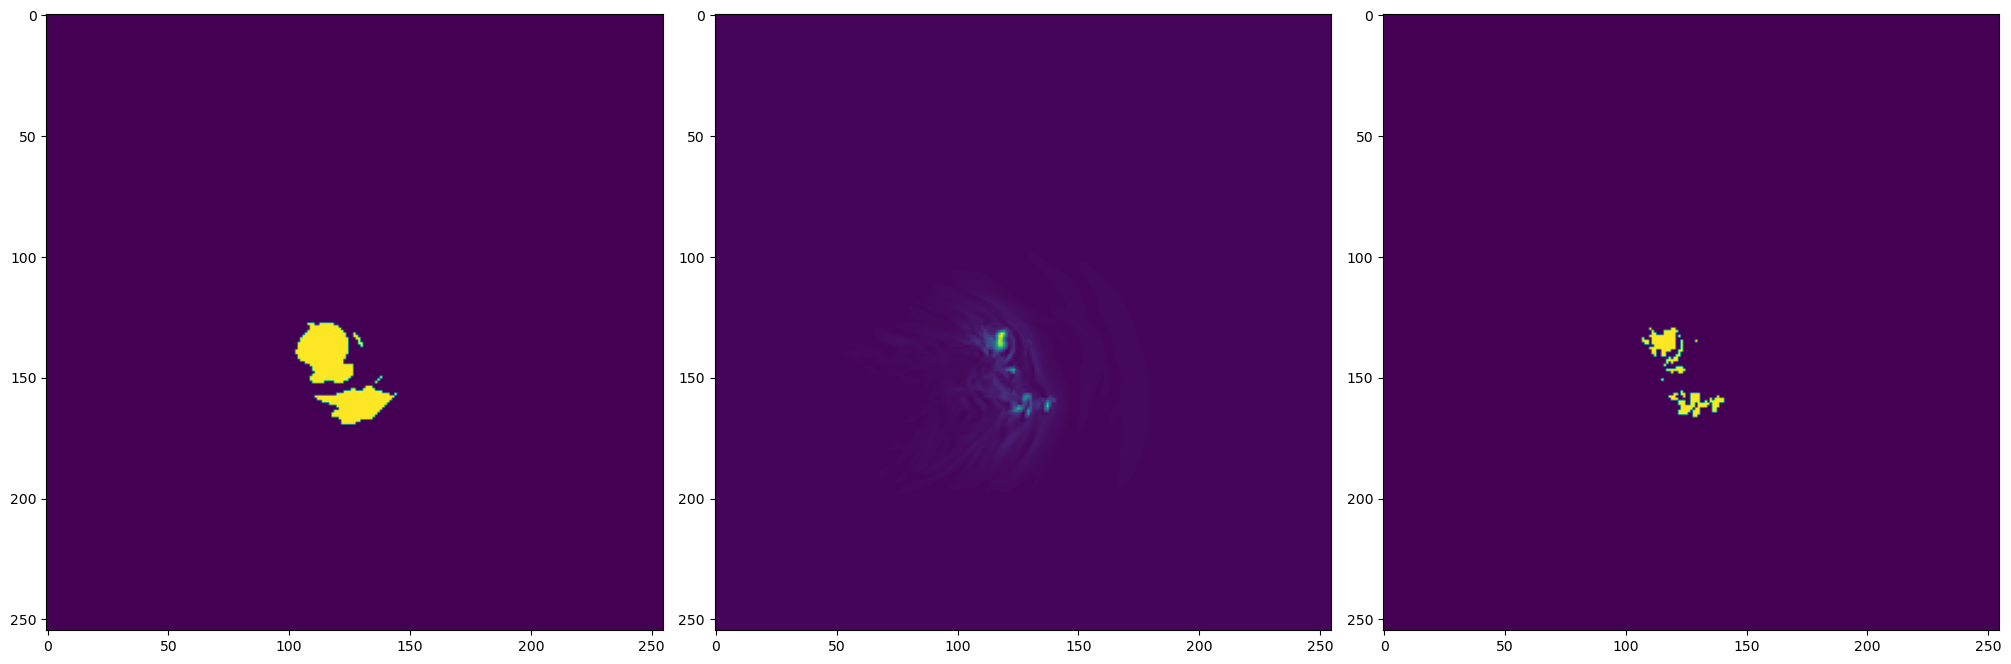

17


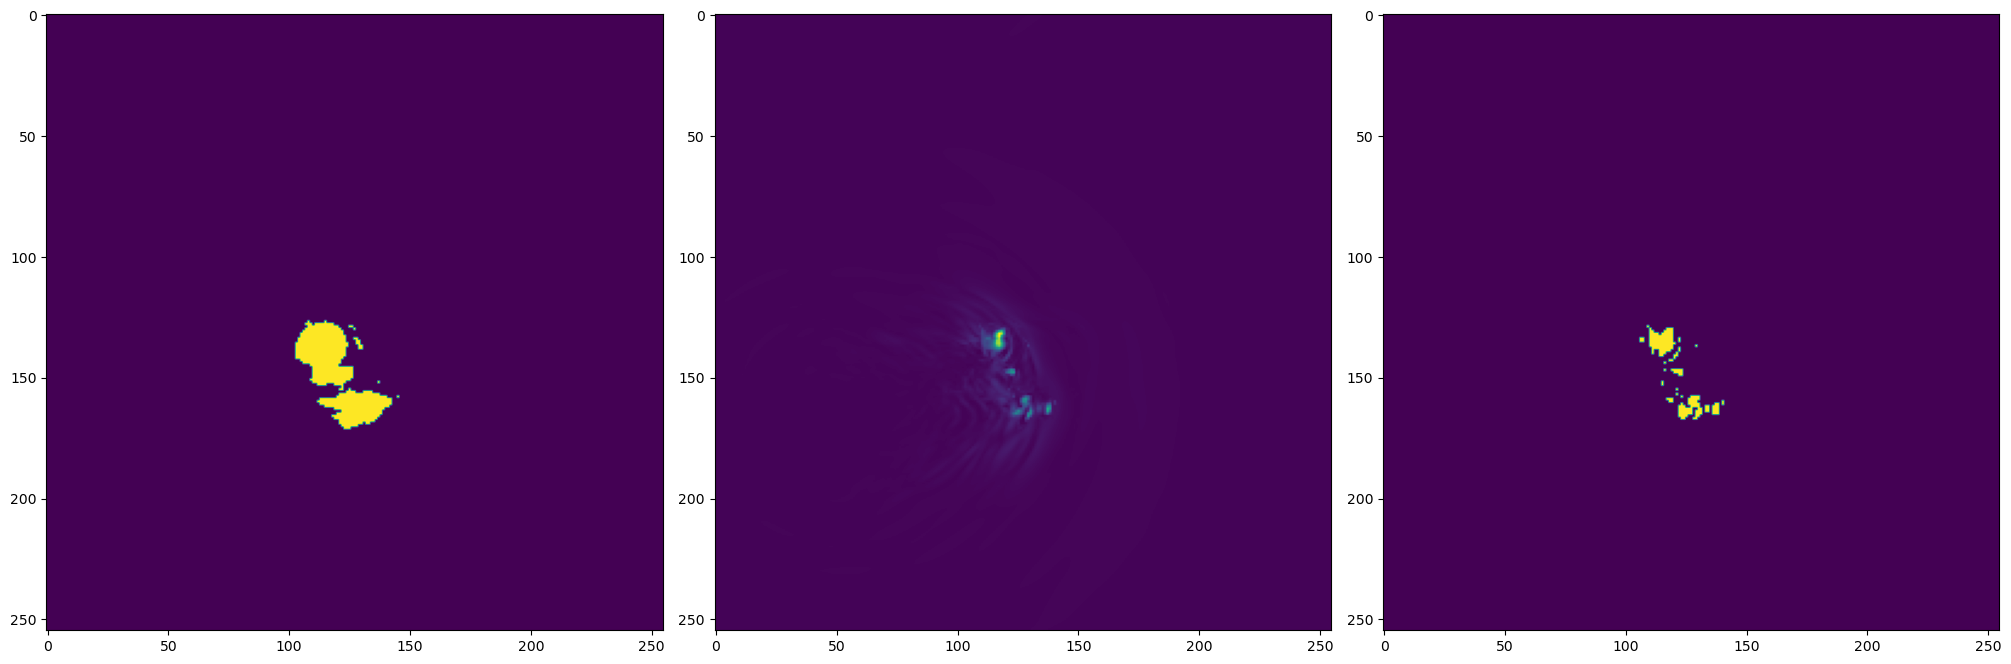

10


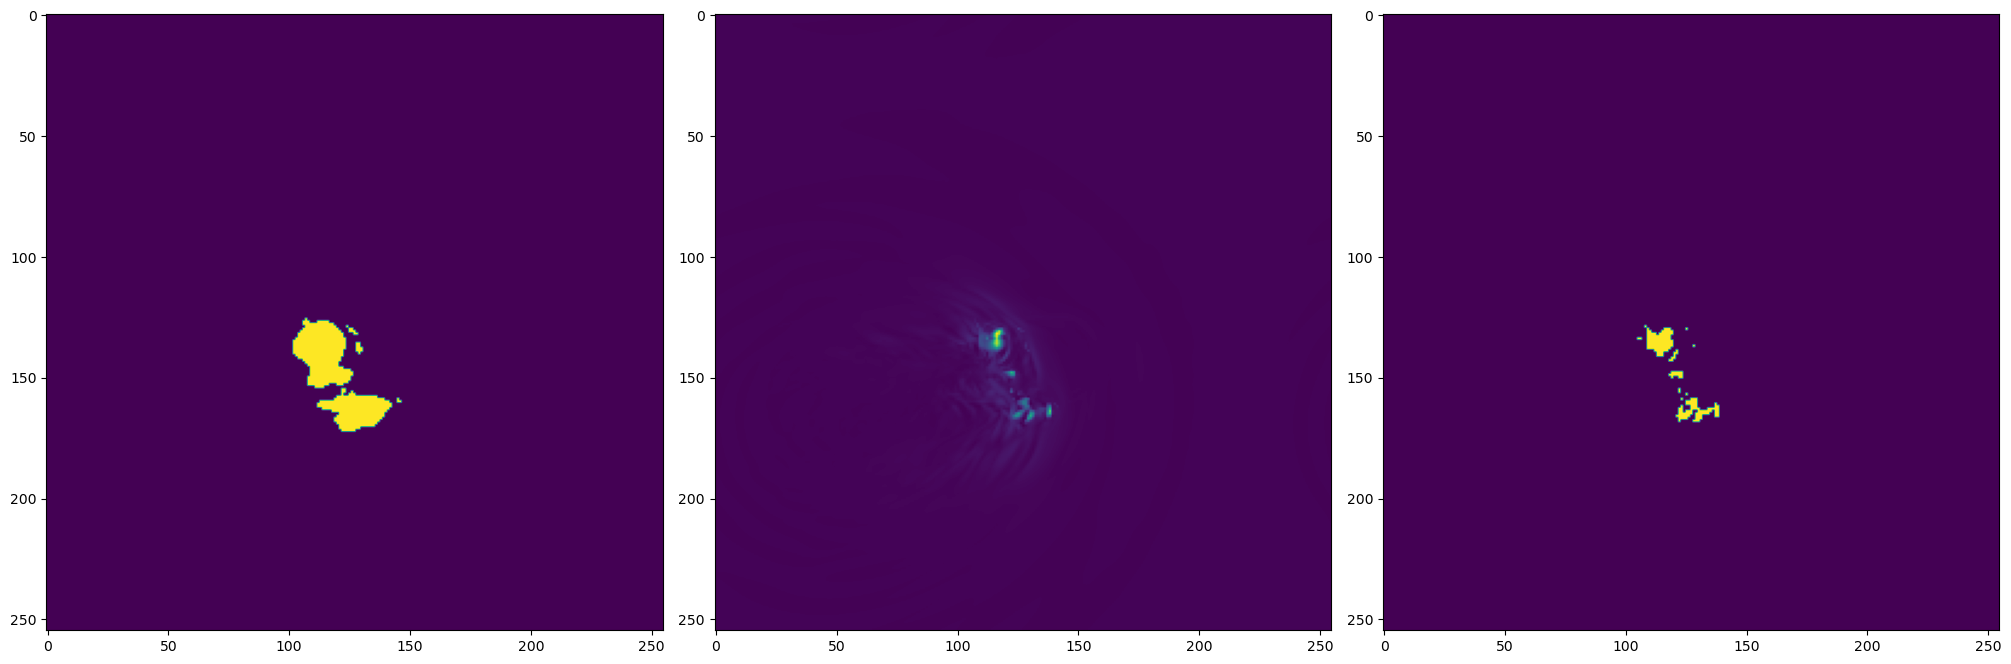

11


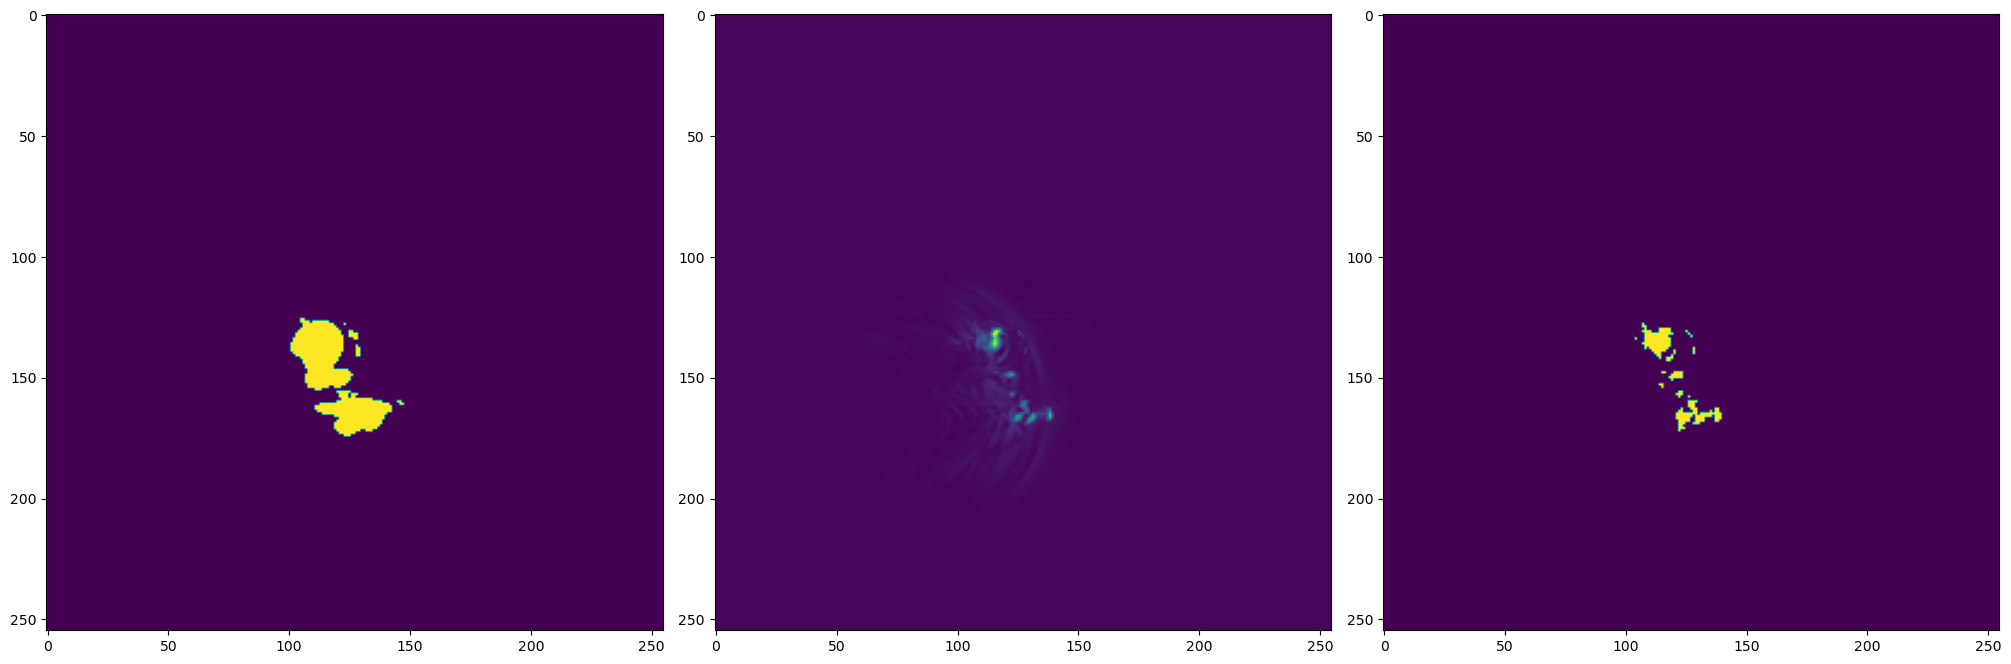

9


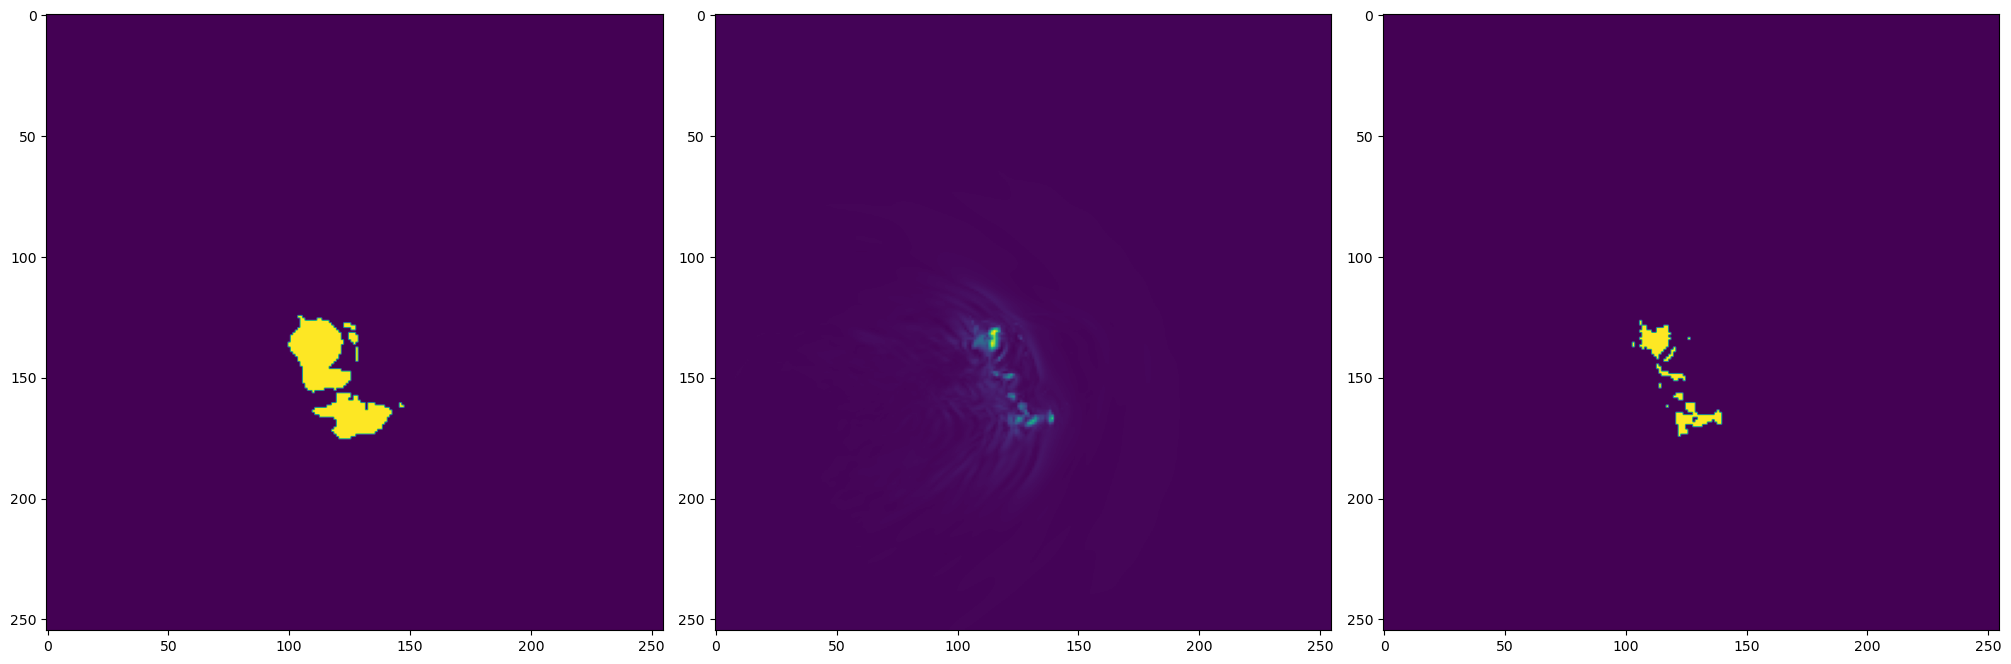

11


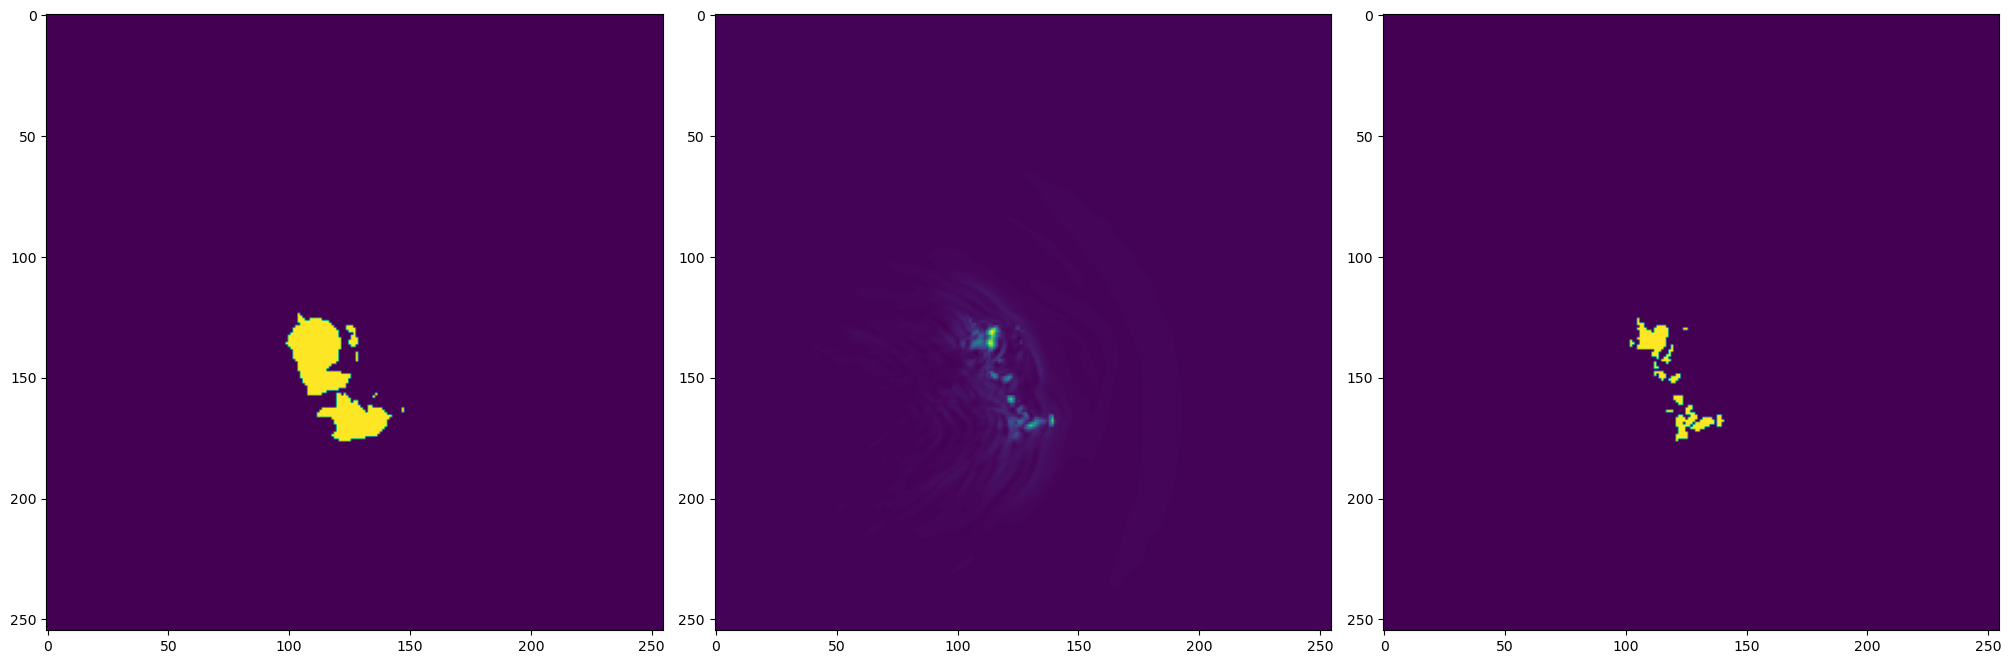

13


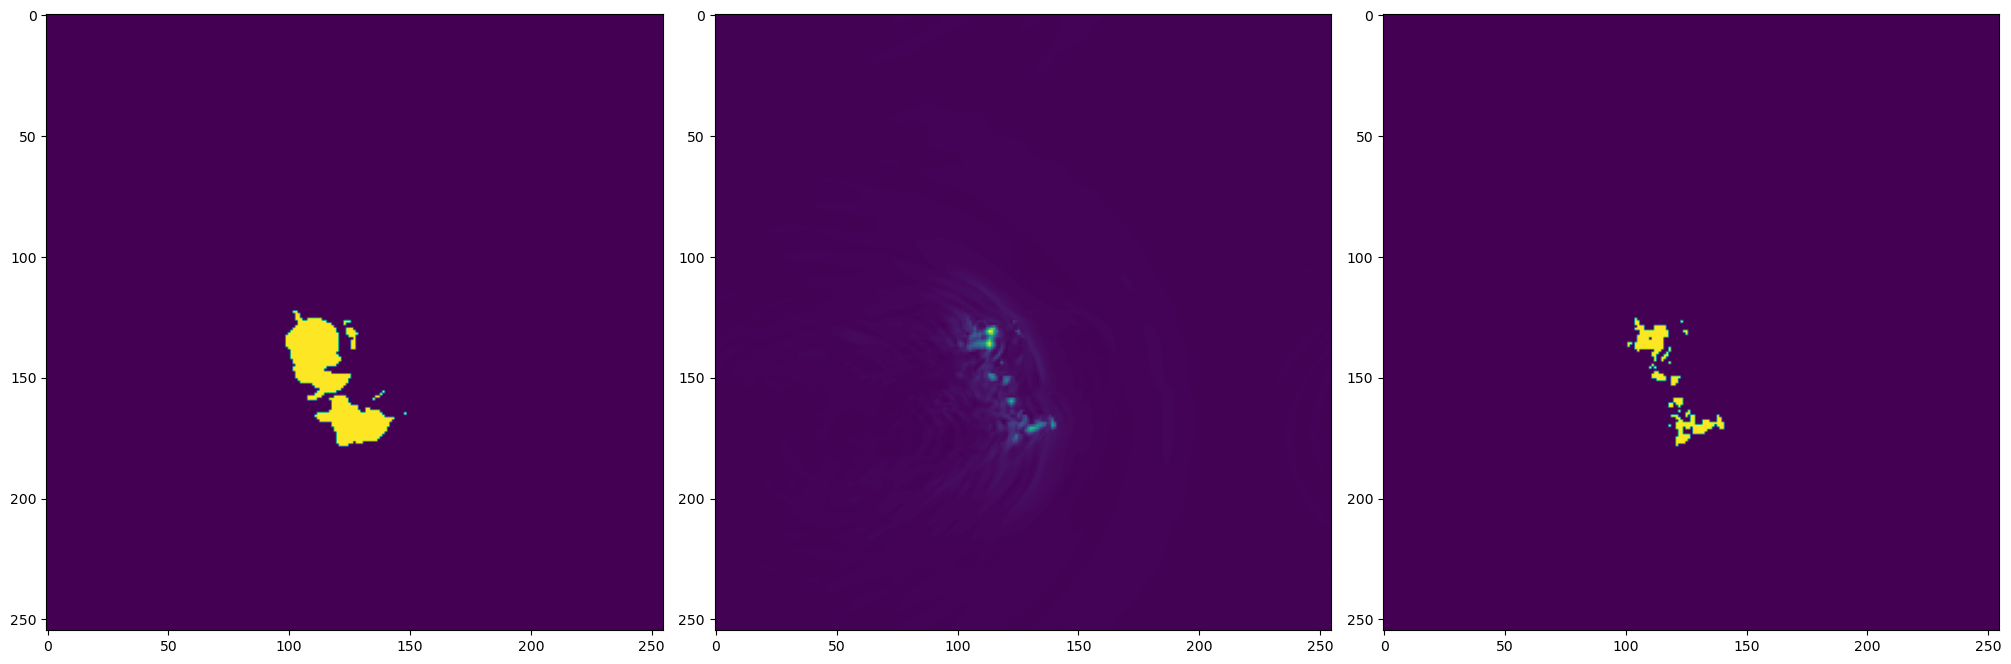

14


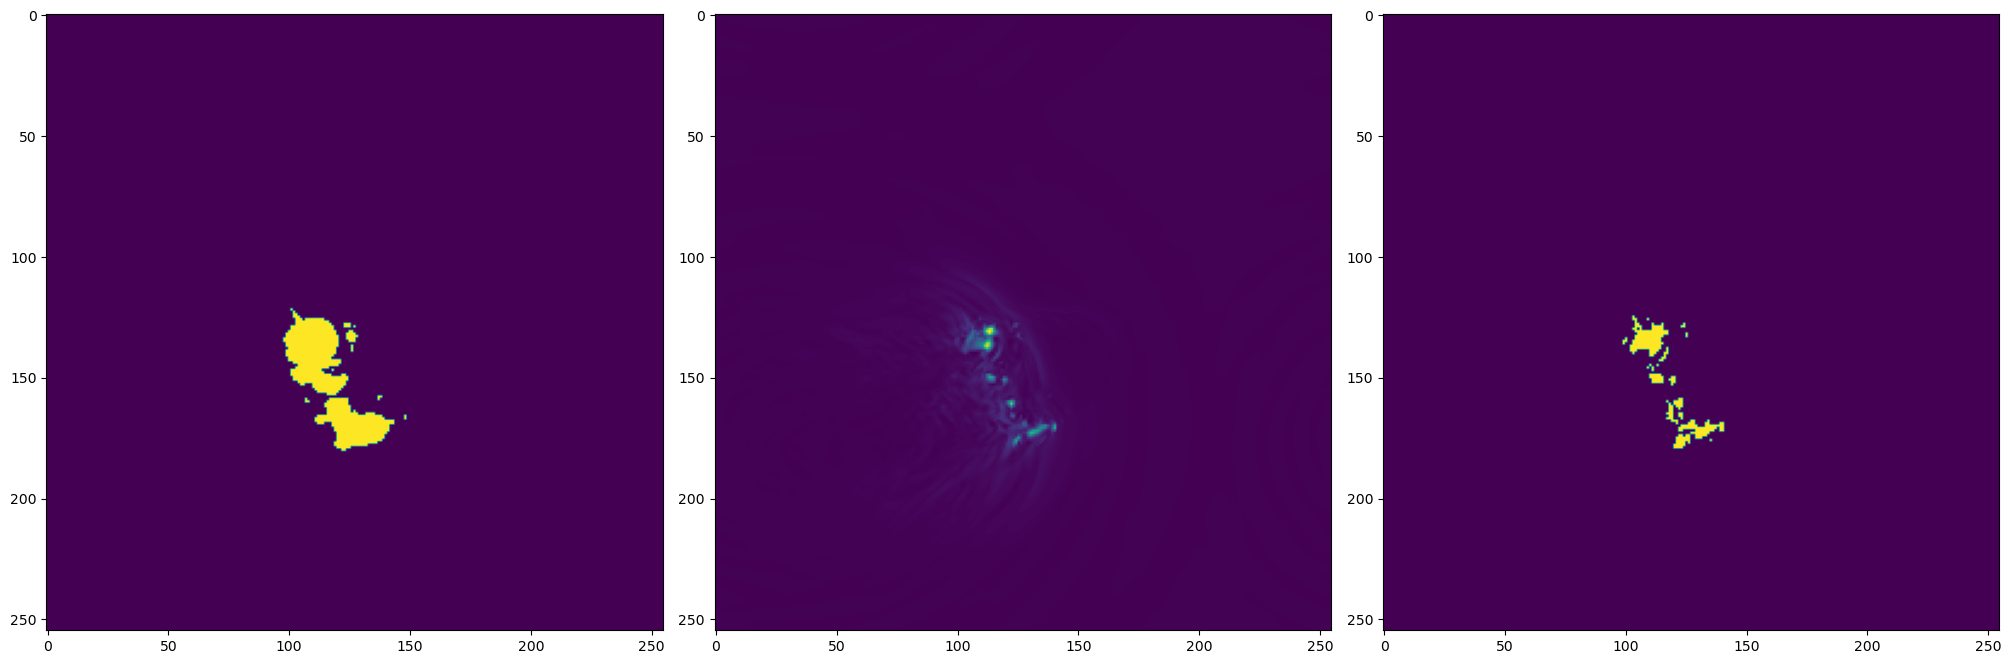

In [10]:
# path = "/work/wicker/Odin_scr/cm1r20.3/run/supercell_3km_C3500"
# ds = tools.CM1_tools.read_cm1_fields(path, file_pattern=None, vars=['pres', 'w',], ret_dbz=True)

path = "/work/wicker/WRF/WRF/test/em_quarter_ss/supercell_3km_qv16/wrfout_d01_0001-01-01_00:00:00"
ds = tools.WRF_tools.read_wrf_fields(path, file_pattern=None, vars=['pres', 'w',], ret_dbz=True)

cref_thresh = 35.
w_thresh = 5.
min_pix = 1

from skimage.measure import label

mask_cref   = np.where(ds['dbz'].max(axis=1) > cref_thresh, True, False)
mask_w_3d   = np.where(ds['pres'] < 70000.0, ds['w'], np.nan)

mask_w_2d   = np.nanmax(mask_w_3d, axis=1)
mask_w_cref = (mask_w_2d > w_thresh) & mask_cref
f_mask      = mask_w_cref.astype(np.int8)

for n in np.arange(10,ds['w'].shape[0]):    
    label_array, num_obj = label(f_mask[n], background=0, connectivity=2, return_num = True)
    
    print(num_obj)
    
    fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(20,10))
    
    ax[0].imshow(mask_cref[n][:,::-1])
    ax[1].imshow(mask_w_2d[n][:,::-1])
    ax[2].imshow(f_mask[n][:,::-1])
    plt.show()


In [10]:
w = pickle2Obj('wrf_supercell_3km_profiles.pkl', retObj=False)

In [11]:
pert_t = w["qv14"]['pert_p']
print(pert_t.shape)

(100, 85)


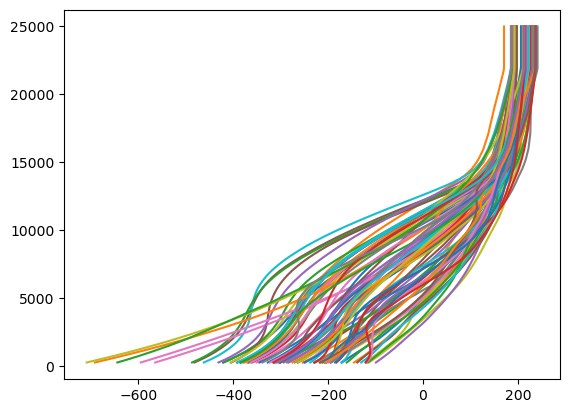

In [12]:
zhgts = 250. + 250.*np.arange(100)
plt.plot(pert_t, zhgts)
plt.show()